In [6]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import yaml
import pprint
import os
import time
import numpy as np
# weights and biases for tracking of metrics
import wandb 
# make the plots inline again
%matplotlib inline
# sometimes have to activate this to plot plots in notebook
# matplotlib.use('Qt5Agg')
from code import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def log_surface_hypersphere(n_dim_sphere, r=1):
    """
    n_dim_sphere of the sphere embedded in the n+1 dimensional Euclidean space
    
    Calculate surface in log space for numerical stability. Work with log gamma function for numerical stability.
    """
    
    s1 = (n_dim_sphere + 1) / 2 * torch.log(torch.tensor(math.pi)) + torch.log(torch.tensor(2.))
    
    s2 = - torch.lgamma( torch.tensor(n_dim_sphere + 1, dtype=torch.float32) / 2)

    s3 = n_dim_sphere * torch.log(torch.tensor(r).float())

    return s1 + s2 + s3


### Create equivalent matrix in arbitrary dimensions

In [8]:
import torch
# import models.transformations.convexp as convexp
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

target = [83., 124., 181.]

target_orange = [255., 186., 126.]

# top = cm.get_cmap('Oranges_r', 128)
# bottom = cm.get_cmap('Blues', 128)
#
# newcolors = np.vstack((top(np.linspace(0, 1, 128)),
#                        bottom(np.linspace(0, 1, 128))))
# newcmp = ListedColormap(newcolors, name='OrangeBlue')

N = 256
blues = np.ones((N, 4))
blues[:, 0] = np.linspace(83./256, 1, N)
blues[:, 1] = np.linspace(124./256, 1, N)
blues[:, 2] = np.linspace(181./256, 1, N)
blues = blues[::-1]
newcmp = ListedColormap(blues)
oranges = np.ones((N, 4))
oranges[:, 0] = np.linspace(target_orange[0] / 256, 1, N)
oranges[:, 1] = np.linspace(target_orange[1] / 256, 1, N)
oranges[:, 2] = np.linspace(target_orange[2] / 256, 1, N)

target_green = [105, 122, 90]
greens = np.ones((N, 4))
greens[:, 0] = np.linspace(target_green[0] / 256, 1, N)
greens[:, 1] = np.linspace(target_green[1] / 256, 1, N)
greens[:, 2] = np.linspace(target_green[2] / 256, 1, N)
greens = greens[::-1]
green_cmp = ListedColormap(greens)


cmp_orange_blue = ListedColormap(np.vstack((oranges, blues)), name='OrangeBlue')

def to_matrix_index(c_idx, C, h_idx, H, w_idx, W):
    return c_idx * (H * W) + h_idx * W + w_idx


def save_matrix(M, name):
    plt.imshow(M, cmap=newcmp, vmin=0, vmax=1.2)
    plt.axis('off')
    plt.savefig(name + ".svg", bbox_inches='tight')


def create_equivalent_matrix(kernel, input_size):
    """
    input_size size of the img (channels, width, height)
    kernel torch.tensor of the kernel/filter/weights
    """
    path = 'equiv_matrix/'
    os.makedirs(path, exist_ok=True)
    

    def convert_kernel_location(y, x, j, i, K1, K2):
        m1 = (K1 - 1) // 2
        m2 = (K2 - 1) // 2
        return y + j - m1, x + i - m2

    C_out, C_in, K1, K2 = kernel.size()

    assert C_in == input_size[0]

    H, W = input_size[1:]

    equiv_matrix = torch.zeros((C_out * H * W, C_in * H * W))

    inp = torch.randn((C_in, H, W))
    out_manual_conv = torch.zeros((C_out, H, W))

    for cout in range(C_out):
        for y in range(H):
            for x in range(W):
                for cin in range(C_in):
                    for j in range(K1):
                        for i in range(K2):
                            v, u = convert_kernel_location(y, x, j, i, K1, K2)

                            if v < 0 or v >= H or u < 0 or u >= W:
                                continue

                            out_manual_conv[cout, y, x] += kernel[cout, cin, j, i] * inp[cin, v, u]

                            j_matrix = to_matrix_index(cout, C_out, y, H, x, W)
                            i_matrix = to_matrix_index(cin, C_in, v, H, u, W)
                            assert equiv_matrix[j_matrix, i_matrix] == 0.
                            equiv_matrix[j_matrix, i_matrix] = kernel[cout, cin, j, i]

    out_pytorch_conv = F.conv2d(inp[None], weight=kernel, bias=None, padding=1)

    inp_vector = inp.view(-1, 1)
    out_vector = torch.mm(equiv_matrix, inp_vector).view(C_out, H, W)

    
    print(f'matrixmul vs pytorch {torch.mean(torch.abs(out_vector - out_pytorch_conv))}')

    print('manual vs pytorch',
          torch.mean(torch.abs(out_manual_conv - out_pytorch_conv)))
  
    print('shape equiv_matrix', equiv_matrix.shape)
    
    plt.imshow(equiv_matrix, cmap=newcmp, vmin=0., vmax=1.2)
    plt.axis('off')
    plt.savefig(path + "equiv_matrix.svg", bbox_inches='tight')
    plt.show()
    
            
    return equiv_matrix
            
     


### create 3 x 3 filter and equivalent 16 x 16 matrix

Filter
tensor([[[[-0.1069, -0.6890, -0.0273],
          [ 0.2258,  1.3929, -0.5442],
          [-0.2799, -0.4668,  0.0240]]]])

matrixmul vs pytorch 7.171183824539185e-08
manual vs pytorch tensor(5.0757e-08)
shape equiv_matrix torch.Size([16, 16])


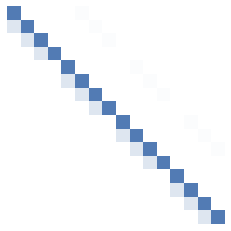

det of equiv matrix 7.705255031585693
true abs determinant 7.705254554748535
true log determinant 2.0419023036956787 



In [9]:
out_channels = 1
in_channels = 1
img_width = 4
img_height = 4

# rand_int = torch.randint(low=0,high=1000,size=(1,))
# print(rand_int)

# 12 seems to be a good seed for a matrix

torch.manual_seed(12)

filter_ = torch.zeros(out_channels, in_channels, 3, 3)
filter_[0,0,1,1] = 1
filter_ = filter_ + torch.randn(out_channels, in_channels, 3, 3) * 0.5

print('Filter')
print(filter_)
print()

equiv_matrix = create_equivalent_matrix(filter_, (1, img_width, img_height))

print(f'det of equiv matrix {torch.det(equiv_matrix)}')

A = equiv_matrix.to(device)

np.save('det_estimate_model/matrix.npy',np.array(A.detach().cpu().numpy()))
np.save('det_estimate_model/filter.npy',np.array(filter_.detach().cpu().numpy()))

print(f'true abs determinant {torch.abs(torch.det(A)).cpu().numpy()}')
print(f'true log determinant {torch.slogdet(A)[1].cpu().numpy()} \n')

### print filter in latex format

In [10]:
def bmatrix(a):
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)

In [13]:
print(bmatrix(np.round(filter_.squeeze().cpu().detach().numpy(),3)))

\begin{bmatrix}
  -0.107 & -0.689 & -0.027\\
  0.226 & 1.393 & -0.544\\
  -0.28 & -0.467 & 0.024\\
\end{bmatrix}


### define 3x3 matrix

### Learn proposal distribution

In [5]:
NUM_CENTERS = 12
NUM_BINS = 16
NUM_FLOWS_COU = 4
# NUM_DIM_DATA
CAP_HOUSEHOLDER_REFL = False
BATCH_SIZE = 1024


### define training function

In [11]:

# first to device, then optimizer

def get_log_f_s(A, s):
    """Calculate  -log f(s) with s ~ q"""
    
    dim = A.shape[0]
    s = s.unsqueeze(-1)

    return - dim * torch.log(torch.norm(torch.matmul(A, s).squeeze(-1), dim=1))
    

def get_mean_neg_ELBO(ldj, log_f_s, log_surface):
    """Calculate KL divergence according to 22.1"""    
    return torch.mean( - ldj - log_f_s)


def train_model(model, 
                optimizer, 
                path,
                A, 
                model_name, 
                max_iter = int(1e3), 
                ELBO_list=None, 
                dj_list=None):

    path_ = f'det_estimate_model/{path}'
    os.makedirs(path, exist_ok=True)
    
    A = A.to(device)
    dim = A.shape[0]
    
    if ELBO_list is None and dj_list is None:
        ELBO_list = []
        dj_list = []
    elif ELBO_list is not None and dj_list is not None:
        ELBO_list = list(ELBO_list)
        dj_list = list(dj_list)
    else:
        raise Exception('Elbo list and dj list have to be both none or not none')
        
        
    log_surface = log_surface_hypersphere(n_dim_sphere = A.shape[0] - 1, r = 1)

    for iter_ in range(len(ELBO_list), max_iter):

        s_0 = torch.randn(BATCH_SIZE, dim).to(device)
        s_0 = s_0 / torch.norm(s_0, dim = 1, keepdim=True) 
        s_0.requires_grad = True

        optimizer.zero_grad()

        s, ldj, _ = model(s_0)

        log_f_s = get_log_f_s(A, s)

        neg_ELBO = get_mean_neg_ELBO(ldj, log_f_s, log_surface)

        neg_ELBO.backward()
        optimizer.step()

        ELBO_list.append(neg_ELBO)

        if iter_ % 10 == 0:
            print(f'at iter {iter_} ELBO loss metric {neg_ELBO}')

        if iter_ % 100 == 0:    
            
            s_0 = torch.randn(int(1e5), dim).to(device)
            s_0 = s_0 / torch.norm(s_0, dim = 1, keepdim=True) 
            
            with torch.no_grad():
                
                _, ldj, _ = model(s_0, inverse=True)
                
            dj_list.append(ldj.exp().mean())

            print(f'\n ldj check {ldj.exp().mean()} \n')            

        # plot stuff
        if iter_ % 200 == 0 and iter_ != 0:
            print(f'Iter {iter_}')
            
            plt.plot(range(len(ELBO_list)), ELBO_list)        
            plt.show()
            plt.plot(range(len(dj_list)), dj_list)        
            plt.show()

        if iter_ % 200 == 0:
            
            print("\n ### SAVE MODEL ### \n")
            
            state = {
                'iter_': iter_,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict()
            }                        

            torch.save(state, f"{path_}/{model_name}.t7") 
            
            import numpy as np
            
            np.save(f"{path_}/ELBO_list_{model_name}.npy",np.array(ELBO_list))
            np.save(f"{path_}/dj_list_{model_name}.npy",np.array(dj_list))

        

### check invertibility 

In [15]:
NUM_CENTERS = 1
NUM_BINS = 16
NUM_FLOWS_COU = 4
NUM_DIM_DATA = 8
CAP_HOUSEHOLDER_REFL = False
BATCH_SIZE = 4


cou_spline = Coupling_Flow(num_flows = NUM_FLOWS_COU, 
                          num_dim_data= NUM_DIM_DATA,
                          flow_type = 'moebius', 
                          rezero_flag=False,
                          num_bins = NUM_BINS,
                          num_centers=NUM_CENTERS,
                          cap_householder_refl=CAP_HOUSEHOLDER_REFL)

cou_spline.to(device)

x = torch.randn(BATCH_SIZE, NUM_DIM_DATA)
x = x / torch.norm(x, dim = 1, keepdim = True)

x = x.to(device)

out, ldj, _  = cou_spline(x)

inv, ldj_inv, _ = cou_spline(out,inverse=True)

print('Circle Slice flows')
print(torch.isclose(x,inv,atol=1e-4))
print(torch.mean(torch.abs(ldj+ldj_inv)))
print()

cyl_cou_moeb = Cylindrical_Flow(num_flows=NUM_FLOWS_COU,
                                 num_bins=NUM_BINS, 
                                 flow_type='spline',
                                 num_dim_data=NUM_DIM_DATA, 
                                 mask_type='coupling',
                                 rezero_flag=False, 
                                 num_centers=NUM_CENTERS)

cyl_cou_moeb.to(device)

x = torch.randn(BATCH_SIZE, NUM_DIM_DATA)
x = x / torch.norm(x, dim = 1, keepdim = True)

x = x.to(device)

out, ldj, _  = cyl_cou_moeb(x)

inv, ldj_inv, _ = cyl_cou_moeb(out,inverse=True)

print('Cylindrical flows')
print(torch.isclose(x,inv,atol=1e-4))
print()
print(torch.mean(torch.abs(ldj+ldj_inv)))

Circle Slice flows
tensor([[True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True]], device='cuda:0')
tensor(2.1681e-06, device='cuda:0', grad_fn=<MeanBackward0>)

Cylindrical flows
tensor([[True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True]], device='cuda:0')

tensor(2.1335e-05, device='cuda:0', grad_fn=<MeanBackward0>)


### check det and eigenvalues of matrices of various matrices

In [17]:
# the seeds correspond to index 0 to 5 in ascending order in /det/estimate_model/3D

seeds = [29, 15, 33, 76, 73]

for i in seeds:
    print(f'seed {i}')
    
    torch.manual_seed(i)
    A = torch.randn(3, 3)

    NUM_DIM_DATA = equiv_matrix.shape[0]
    33, 76
    print(A)


    print(f'true abs determinant {torch.abs(torch.det(A)).cpu().numpy()}')
    print(f'true log determinant {torch.slogdet(A)[1].cpu().numpy()} \n')

    print(torch.eig(A,eigenvectors=False))
    print()

seed 29
tensor([[ 1.1474, -0.1417,  0.4743],
        [ 0.0876,  0.6843,  1.2199],
        [ 0.7503,  1.0337, -0.1682]])
true abs determinant 1.9111394882202148
true log determinant 0.6476997137069702 

torch.return_types.eig(
eigenvalues=tensor([[-1.0679,  0.0000],
        [ 1.0909,  0.0000],
        [ 1.6405,  0.0000]]),
eigenvectors=tensor([]))

seed 15
tensor([[-0.7056,  0.6741, -0.5454],
        [ 0.9107,  1.0682,  0.1424],
        [-1.2754, -0.1769,  1.0084]])
true abs determinant 2.174506902694702
true log determinant 0.7768018841743469 

torch.return_types.eig(
eigenvalues=tensor([[-1.2758,  0.0000],
        [ 1.5401,  0.0000],
        [ 1.1066,  0.0000]]),
eigenvectors=tensor([]))

seed 33
tensor([[ 1.1982, -0.3998, -0.3476],
        [-0.2759, -2.3094, -1.0931],
        [-0.0808,  0.7721, -1.1370]])
true abs determinant 4.386593341827393
true log determinant 1.478553056716919 

torch.return_types.eig(
eigenvalues=tensor([[ 1.2413,  0.0000],
        [-1.7448,  0.6996],
        [

### train models combined - Circle Slice and Cylindrical Flows

In [9]:
NUM_CENTERS = 12
NUM_BINS = 32
NUM_FLOWS_COU = 6

NUM_DIM_DATA = 3
CAP_HOUSEHOLDER_REFL = False
BATCH_SIZE = 1024


# original list of seeds

def train_both_models_combined(seeds, path):

    for i, seed in enumerate(seeds):

        max_iter = int(2e3)

        print()
        print(f'run {i} with seed {seed}')

        torch.manual_seed(seed)
        A = torch.randn(3, 3)

        NUM_DIM_DATA = A.shape[0]

        print(f'det {torch.det(A)}')

        A = A.to(device)
        print(A)

#         np.save(f'det_estimate_model/{path}/matrix_in_3d_{i}.npy',np.array(A.detach().cpu().numpy()))

        print(f'true abs determinant {torch.abs(torch.det(A)).cpu().numpy()}')
        print(f'true log determinant {torch.slogdet(A)[1].cpu().numpy()} \n')

        print(torch.eig(A,eigenvectors=False))
        print()
        
        integ = np.random.randint(100)
        
        torch.manual_seed(integ)
        
        
        ### cylindrical ar spline model
        cyl_cou_moeb = Cylindrical_Flow(num_flows=NUM_FLOWS_COU,
                                         num_bins=NUM_BINS, 
                                         flow_type='spline',
                                         num_dim_data=NUM_DIM_DATA, 
                                         mask_type='autoregressive',
                                         num_centers=NUM_CENTERS)

        cyl_cou_moeb.to(device)

        optimizer_cyl_cou = optim.AdamW(cyl_cou_moeb.parameters())

        

        train_model(cyl_cou_moeb, 
                    optimizer_cyl_cou,
                    path,
                    A, 
                    model_name=f'cyl_ar_spline_in_3d_{i}', 
                    max_iter = max_iter)    



        ### CSF coupling spline model 
        cou_spline = Coupling_Flow(num_flows = NUM_FLOWS_COU, 
                                      num_dim_data= NUM_DIM_DATA,
                                      flow_type = 'spline', 
                                      num_centers = NUM_CENTERS,
                                      num_bins=NUM_BINS,
                                      cap_householder_refl=CAP_HOUSEHOLDER_REFL)

        cou_spline.to(device)

        optimizer = optim.AdamW(cou_spline.parameters())

        train_model(cou_spline, 
                    optimizer, 
                    path,
                    A, 
                    model_name=f'cou_spline_in_3d_{i}', 
                    max_iter = max_iter)    


run 0 with seed 29
det -1.9111394882202148
tensor([[ 1.1474, -0.1417,  0.4743],
        [ 0.0876,  0.6843,  1.2199],
        [ 0.7503,  1.0337, -0.1682]], device='cuda:0')
true abs determinant 1.9111394882202148
true log determinant 0.6476996541023254 

torch.return_types.eig(
eigenvalues=tensor([[-1.0679,  0.0000],
        [ 1.0909,  0.0000],
        [ 1.6405,  0.0000]], device='cuda:0'),
eigenvectors=tensor([], device='cuda:0'))

at iter 0 ELBO loss metric 0.7538895010948181

 ldj check 0.9999991655349731 


 ### SAVE MODEL ### 



/home/simon/ENTER/envs/flow_lab/lib/python3.8/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


at iter 10 ELBO loss metric 0.7405081987380981
at iter 20 ELBO loss metric 0.7233709096908569
at iter 30 ELBO loss metric 0.686236560344696
at iter 40 ELBO loss metric 0.6852286458015442
at iter 50 ELBO loss metric 0.6789774894714355
at iter 60 ELBO loss metric 0.6865631341934204
at iter 70 ELBO loss metric 0.6598168015480042
at iter 80 ELBO loss metric 0.6636266708374023
at iter 90 ELBO loss metric 0.6663267612457275
at iter 100 ELBO loss metric 0.661920428276062

 ldj check 1.0002027750015259 

at iter 110 ELBO loss metric 0.6585946679115295
at iter 120 ELBO loss metric 0.6627478003501892
at iter 130 ELBO loss metric 0.6582076549530029
at iter 140 ELBO loss metric 0.6573512554168701
at iter 150 ELBO loss metric 0.661594033241272
at iter 160 ELBO loss metric 0.6610730886459351
at iter 170 ELBO loss metric 0.6610883474349976
at iter 180 ELBO loss metric 0.6497493982315063
at iter 190 ELBO loss metric 0.6537312269210815
at iter 200 ELBO loss metric 0.6563102006912231

 ldj check 0.99985

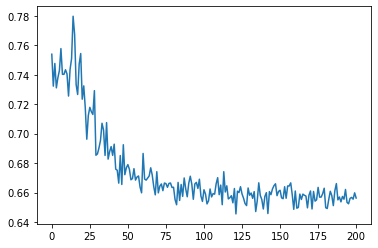

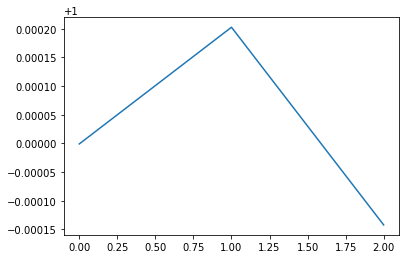


 ### SAVE MODEL ### 

at iter 210 ELBO loss metric 0.6481761336326599
at iter 220 ELBO loss metric 0.6584329605102539
at iter 230 ELBO loss metric 0.6517705321311951
at iter 240 ELBO loss metric 0.6561433672904968
at iter 250 ELBO loss metric 0.6534256935119629
at iter 260 ELBO loss metric 0.6567355394363403
at iter 270 ELBO loss metric 0.6570245027542114
at iter 280 ELBO loss metric 0.6623114943504333
at iter 290 ELBO loss metric 0.6605722904205322
at iter 300 ELBO loss metric 0.6534360647201538

 ldj check 1.003208875656128 

at iter 310 ELBO loss metric 0.6512098908424377
at iter 320 ELBO loss metric 0.6498637199401855
at iter 330 ELBO loss metric 0.6531537771224976
at iter 340 ELBO loss metric 0.654631495475769
at iter 350 ELBO loss metric 0.6562227606773376
at iter 360 ELBO loss metric 0.6579699516296387
at iter 370 ELBO loss metric 0.6555811166763306
at iter 380 ELBO loss metric 0.6532076597213745
at iter 390 ELBO loss metric 0.6578168869018555
at iter 400 ELBO loss metric 0.647

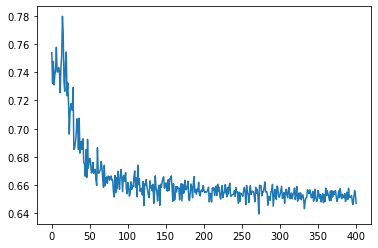

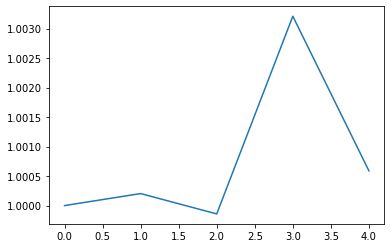


 ### SAVE MODEL ### 

at iter 410 ELBO loss metric 0.6530446410179138
at iter 420 ELBO loss metric 0.6490269303321838
at iter 430 ELBO loss metric 0.6546306610107422
at iter 440 ELBO loss metric 0.6554815769195557
at iter 450 ELBO loss metric 0.6493774056434631
at iter 460 ELBO loss metric 0.655364453792572
at iter 470 ELBO loss metric 0.6538370847702026
at iter 480 ELBO loss metric 0.6509290933609009
at iter 490 ELBO loss metric 0.6538581848144531
at iter 500 ELBO loss metric 0.6466765403747559

 ldj check 0.9995173215866089 

at iter 510 ELBO loss metric 0.6497660875320435
at iter 520 ELBO loss metric 0.6535260677337646
at iter 530 ELBO loss metric 0.6540737152099609
at iter 540 ELBO loss metric 0.6548842191696167
at iter 550 ELBO loss metric 0.6511892080307007
at iter 560 ELBO loss metric 0.6536641120910645
at iter 570 ELBO loss metric 0.6467102766036987
at iter 580 ELBO loss metric 0.6504690647125244
at iter 590 ELBO loss metric 0.6454007625579834
at iter 600 ELBO loss metric 0.65

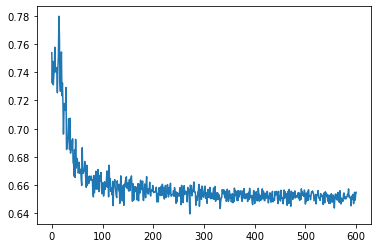

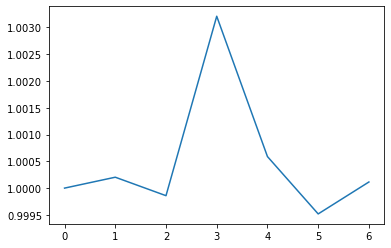


 ### SAVE MODEL ### 

at iter 610 ELBO loss metric 0.6509941816329956
at iter 620 ELBO loss metric 0.6488587260246277
at iter 630 ELBO loss metric 0.646255373954773
at iter 640 ELBO loss metric 0.6496648788452148
at iter 650 ELBO loss metric 0.6522351503372192
at iter 660 ELBO loss metric 0.6517817378044128
at iter 670 ELBO loss metric 0.6518756151199341
at iter 680 ELBO loss metric 0.6511121988296509
at iter 690 ELBO loss metric 0.65503990650177
at iter 700 ELBO loss metric 0.6503792405128479

 ldj check 0.9996219277381897 

at iter 710 ELBO loss metric 0.6506542563438416
at iter 720 ELBO loss metric 0.6459574699401855
at iter 730 ELBO loss metric 0.6509609222412109
at iter 740 ELBO loss metric 0.6499004364013672
at iter 750 ELBO loss metric 0.6515706777572632
at iter 760 ELBO loss metric 0.6513521671295166
at iter 770 ELBO loss metric 0.6503495573997498
at iter 780 ELBO loss metric 0.6534260511398315
at iter 790 ELBO loss metric 0.6559493541717529
at iter 800 ELBO loss metric 0.6550

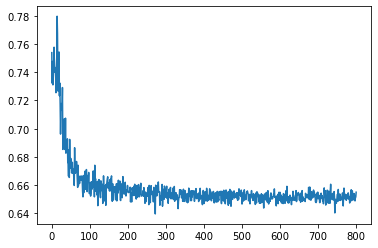

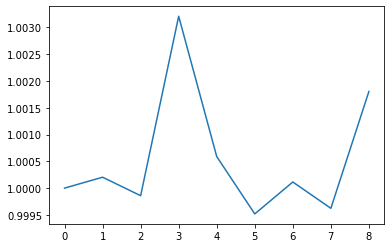


 ### SAVE MODEL ### 

at iter 810 ELBO loss metric 0.652577817440033
at iter 820 ELBO loss metric 0.647589385509491
at iter 830 ELBO loss metric 0.6460750102996826
at iter 840 ELBO loss metric 0.6517561078071594
at iter 850 ELBO loss metric 0.6526988744735718
at iter 860 ELBO loss metric 0.6515324711799622
at iter 870 ELBO loss metric 0.6472307443618774
at iter 880 ELBO loss metric 0.6524621248245239
at iter 890 ELBO loss metric 0.6490675210952759
at iter 900 ELBO loss metric 0.6509956121444702

 ldj check 0.99821937084198 

at iter 910 ELBO loss metric 0.6532348394393921
at iter 920 ELBO loss metric 0.6543123722076416
at iter 930 ELBO loss metric 0.651220440864563
at iter 940 ELBO loss metric 0.6548691987991333
at iter 950 ELBO loss metric 0.6566616892814636
at iter 960 ELBO loss metric 0.6551296710968018
at iter 970 ELBO loss metric 0.6509479284286499
at iter 980 ELBO loss metric 0.6497573256492615
at iter 990 ELBO loss metric 0.6487331390380859
at iter 1000 ELBO loss metric 0.65098

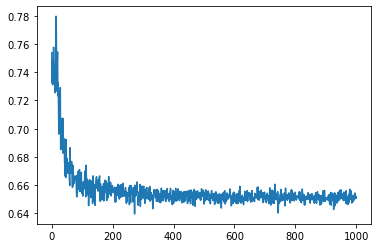

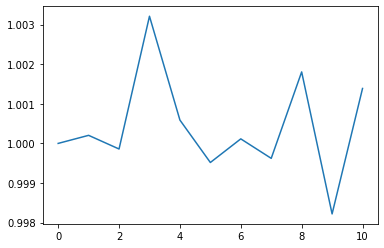


 ### SAVE MODEL ### 

at iter 1010 ELBO loss metric 0.6503083109855652
at iter 1020 ELBO loss metric 0.6489146947860718
at iter 1030 ELBO loss metric 0.651503324508667
at iter 1040 ELBO loss metric 0.649053692817688
at iter 1050 ELBO loss metric 0.6477950215339661
at iter 1060 ELBO loss metric 0.6468065977096558
at iter 1070 ELBO loss metric 0.6513922214508057
at iter 1080 ELBO loss metric 0.653624415397644
at iter 1090 ELBO loss metric 0.6517883539199829
at iter 1100 ELBO loss metric 0.6499985456466675

 ldj check 1.0013136863708496 

at iter 1110 ELBO loss metric 0.6478714942932129
at iter 1120 ELBO loss metric 0.6493512988090515
at iter 1130 ELBO loss metric 0.6497474312782288
at iter 1140 ELBO loss metric 0.6495188474655151
at iter 1150 ELBO loss metric 0.6491183042526245
at iter 1160 ELBO loss metric 0.6493333578109741
at iter 1170 ELBO loss metric 0.6560586094856262
at iter 1180 ELBO loss metric 0.6537131071090698
at iter 1190 ELBO loss metric 0.6517094373703003
at iter 1200 ELB

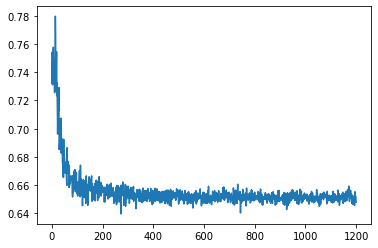

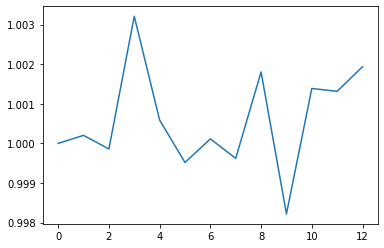


 ### SAVE MODEL ### 

at iter 1210 ELBO loss metric 0.6507748961448669
at iter 1220 ELBO loss metric 0.6514881253242493
at iter 1230 ELBO loss metric 0.6547884941101074
at iter 1240 ELBO loss metric 0.6514502167701721
at iter 1250 ELBO loss metric 0.6536713242530823
at iter 1260 ELBO loss metric 0.650621771812439
at iter 1270 ELBO loss metric 0.6507980823516846
at iter 1280 ELBO loss metric 0.6482596397399902
at iter 1290 ELBO loss metric 0.6557607054710388
at iter 1300 ELBO loss metric 0.6548776626586914

 ldj check 0.9989833831787109 

at iter 1310 ELBO loss metric 0.6535428762435913
at iter 1320 ELBO loss metric 0.6506420373916626
at iter 1330 ELBO loss metric 0.6471142172813416
at iter 1340 ELBO loss metric 0.6478970050811768
at iter 1350 ELBO loss metric 0.6515378952026367
at iter 1360 ELBO loss metric 0.6472558975219727
at iter 1370 ELBO loss metric 0.6491154432296753
at iter 1380 ELBO loss metric 0.6491255760192871
at iter 1390 ELBO loss metric 0.6483052968978882
at iter 1400 E

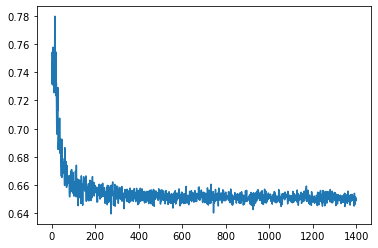

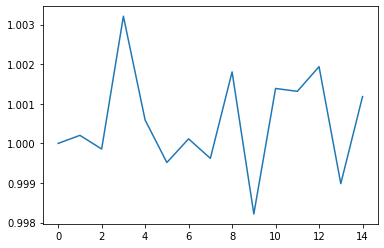


 ### SAVE MODEL ### 

at iter 1410 ELBO loss metric 0.6507340669631958
at iter 1420 ELBO loss metric 0.6500740051269531
at iter 1430 ELBO loss metric 0.6512136459350586
at iter 1440 ELBO loss metric 0.6506994962692261
at iter 1450 ELBO loss metric 0.6475890874862671
at iter 1460 ELBO loss metric 0.6504873037338257
at iter 1470 ELBO loss metric 0.6485795378684998
at iter 1480 ELBO loss metric 0.6510626077651978
at iter 1490 ELBO loss metric 0.6554391384124756
at iter 1500 ELBO loss metric 0.6544158458709717

 ldj check 1.0002648830413818 

at iter 1510 ELBO loss metric 0.6490518450737
at iter 1520 ELBO loss metric 0.6559538245201111
at iter 1530 ELBO loss metric 0.6526137590408325
at iter 1540 ELBO loss metric 0.6532859802246094
at iter 1550 ELBO loss metric 0.6518354415893555
at iter 1560 ELBO loss metric 0.6521340608596802
at iter 1570 ELBO loss metric 0.650026798248291
at iter 1580 ELBO loss metric 0.6481091976165771
at iter 1590 ELBO loss metric 0.650915801525116
at iter 1600 ELBO 

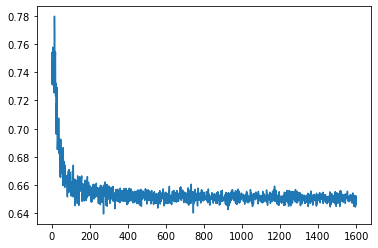

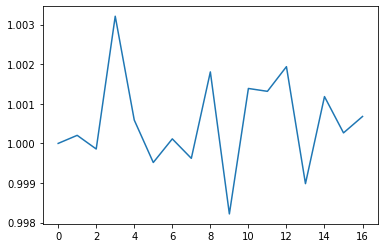


 ### SAVE MODEL ### 

at iter 1610 ELBO loss metric 0.6516896486282349
at iter 1620 ELBO loss metric 0.6507979035377502
at iter 1630 ELBO loss metric 0.6505831480026245
at iter 1640 ELBO loss metric 0.6467888355255127
at iter 1650 ELBO loss metric 0.6493476629257202
at iter 1660 ELBO loss metric 0.6519633531570435
at iter 1670 ELBO loss metric 0.654721736907959
at iter 1680 ELBO loss metric 0.6516979932785034
at iter 1690 ELBO loss metric 0.6507877111434937
at iter 1700 ELBO loss metric 0.6556650996208191

 ldj check 0.9997353553771973 

at iter 1710 ELBO loss metric 0.6513891220092773
at iter 1720 ELBO loss metric 0.6546168923377991
at iter 1730 ELBO loss metric 0.6470031142234802
at iter 1740 ELBO loss metric 0.6509865522384644
at iter 1750 ELBO loss metric 0.650917112827301
at iter 1760 ELBO loss metric 0.6507239937782288
at iter 1770 ELBO loss metric 0.6515421867370605
at iter 1780 ELBO loss metric 0.6525174379348755
at iter 1790 ELBO loss metric 0.6507830619812012
at iter 1800 EL

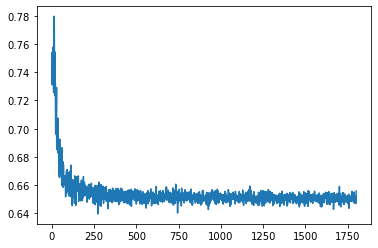

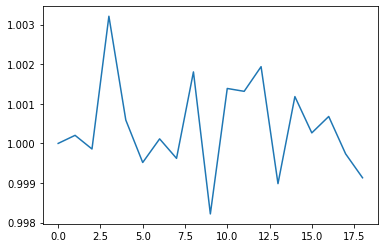


 ### SAVE MODEL ### 

at iter 1810 ELBO loss metric 0.6494001746177673
at iter 1820 ELBO loss metric 0.6520392894744873
at iter 1830 ELBO loss metric 0.649586021900177
at iter 1840 ELBO loss metric 0.6494262218475342
at iter 1850 ELBO loss metric 0.6560737490653992
at iter 1860 ELBO loss metric 0.6529954671859741
at iter 1870 ELBO loss metric 0.6512471437454224
at iter 1880 ELBO loss metric 0.647881269454956
at iter 1890 ELBO loss metric 0.653312623500824
at iter 1900 ELBO loss metric 0.6502950191497803

 ldj check 0.9991270899772644 

at iter 1910 ELBO loss metric 0.6529082655906677
at iter 1920 ELBO loss metric 0.6482336521148682
at iter 1930 ELBO loss metric 0.6533718109130859
at iter 1940 ELBO loss metric 0.6508942246437073
at iter 1950 ELBO loss metric 0.6536706686019897
at iter 1960 ELBO loss metric 0.6483043432235718
at iter 1970 ELBO loss metric 0.6533579230308533
at iter 1980 ELBO loss metric 0.6486014127731323
at iter 1990 ELBO loss metric 0.6476072072982788
at iter 0 ELBO l

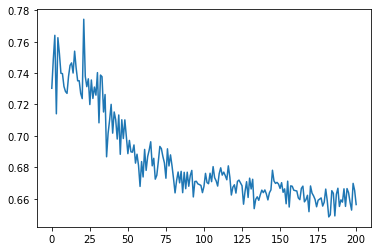

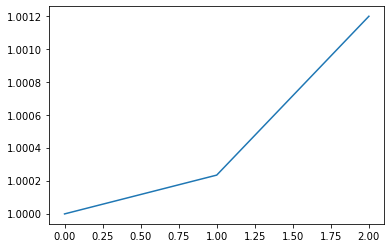


 ### SAVE MODEL ### 

at iter 210 ELBO loss metric 0.6621540188789368
at iter 220 ELBO loss metric 0.6609544157981873
at iter 230 ELBO loss metric 0.6608132123947144
at iter 240 ELBO loss metric 0.6636196374893188
at iter 250 ELBO loss metric 0.6572393178939819
at iter 260 ELBO loss metric 0.6597104668617249
at iter 270 ELBO loss metric 0.6543092727661133
at iter 280 ELBO loss metric 0.6547563672065735
at iter 290 ELBO loss metric 0.6608725786209106
at iter 300 ELBO loss metric 0.644056499004364

 ldj check 1.0000053644180298 

at iter 310 ELBO loss metric 0.662423312664032
at iter 320 ELBO loss metric 0.6564158201217651
at iter 330 ELBO loss metric 0.661396324634552
at iter 340 ELBO loss metric 0.6548407077789307
at iter 350 ELBO loss metric 0.6574949026107788
at iter 360 ELBO loss metric 0.6573746204376221
at iter 370 ELBO loss metric 0.6606089472770691
at iter 380 ELBO loss metric 0.6635808944702148
at iter 390 ELBO loss metric 0.6627353429794312
at iter 400 ELBO loss metric 0.6499

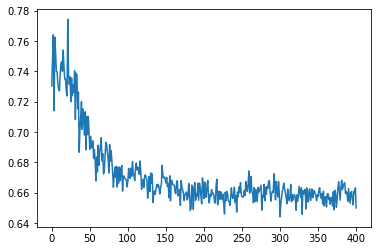

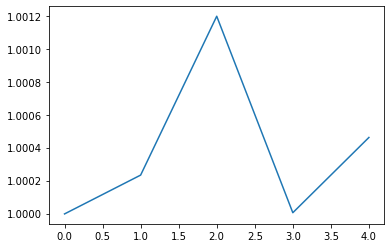


 ### SAVE MODEL ### 

at iter 410 ELBO loss metric 0.6574795246124268
at iter 420 ELBO loss metric 0.6495978832244873
at iter 430 ELBO loss metric 0.6547889709472656
at iter 440 ELBO loss metric 0.6466677784919739
at iter 450 ELBO loss metric 0.6536847352981567
at iter 460 ELBO loss metric 0.6536678671836853
at iter 470 ELBO loss metric 0.6551803350448608
at iter 480 ELBO loss metric 0.6604348421096802
at iter 490 ELBO loss metric 0.6538625359535217
at iter 500 ELBO loss metric 0.6516709327697754

 ldj check 0.999876856803894 

at iter 510 ELBO loss metric 0.649442195892334
at iter 520 ELBO loss metric 0.6491153836250305
at iter 530 ELBO loss metric 0.6520266532897949
at iter 540 ELBO loss metric 0.6517441272735596
at iter 550 ELBO loss metric 0.6582105755805969
at iter 560 ELBO loss metric 0.6573099493980408
at iter 570 ELBO loss metric 0.6604675054550171
at iter 580 ELBO loss metric 0.6550101637840271
at iter 590 ELBO loss metric 0.6532659530639648
at iter 600 ELBO loss metric 0.654

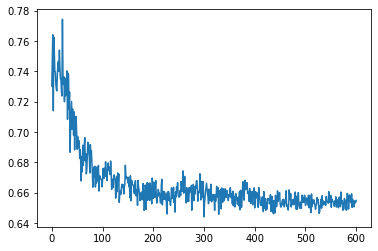

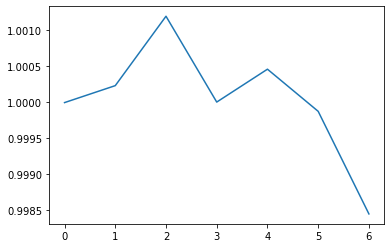


 ### SAVE MODEL ### 

at iter 610 ELBO loss metric 0.6541481018066406
at iter 620 ELBO loss metric 0.6490861177444458
at iter 630 ELBO loss metric 0.651502251625061
at iter 640 ELBO loss metric 0.6514379978179932
at iter 650 ELBO loss metric 0.6467767953872681
at iter 660 ELBO loss metric 0.6512607336044312
at iter 670 ELBO loss metric 0.6540664434432983
at iter 680 ELBO loss metric 0.6489912271499634
at iter 690 ELBO loss metric 0.6511334776878357
at iter 700 ELBO loss metric 0.6510176658630371

 ldj check 0.9980446100234985 

at iter 710 ELBO loss metric 0.6565251350402832
at iter 720 ELBO loss metric 0.6502265930175781
at iter 730 ELBO loss metric 0.6539437174797058
at iter 740 ELBO loss metric 0.6490069031715393
at iter 750 ELBO loss metric 0.6528269052505493
at iter 760 ELBO loss metric 0.6547783613204956
at iter 770 ELBO loss metric 0.6525128483772278
at iter 780 ELBO loss metric 0.6534692049026489
at iter 790 ELBO loss metric 0.650769829750061
at iter 800 ELBO loss metric 0.651

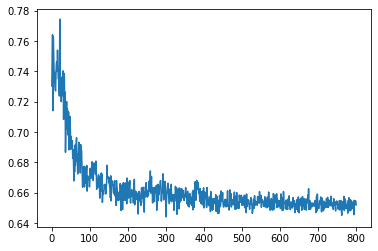

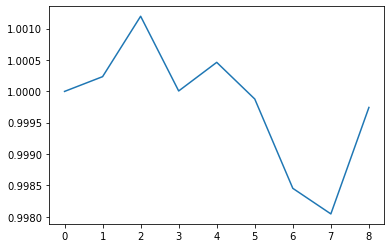


 ### SAVE MODEL ### 

at iter 810 ELBO loss metric 0.649677574634552
at iter 820 ELBO loss metric 0.65169358253479
at iter 830 ELBO loss metric 0.6520728468894958
at iter 840 ELBO loss metric 0.6502048969268799
at iter 850 ELBO loss metric 0.6478831768035889
at iter 860 ELBO loss metric 0.649565577507019
at iter 870 ELBO loss metric 0.6526806950569153
at iter 880 ELBO loss metric 0.6532161235809326
at iter 890 ELBO loss metric 0.6535756587982178
at iter 900 ELBO loss metric 0.6570331454277039

 ldj check 1.0006215572357178 

at iter 910 ELBO loss metric 0.6504327058792114
at iter 920 ELBO loss metric 0.6489481925964355
at iter 930 ELBO loss metric 0.6513670086860657
at iter 940 ELBO loss metric 0.6487108469009399
at iter 950 ELBO loss metric 0.6553360819816589
at iter 960 ELBO loss metric 0.65398108959198
at iter 970 ELBO loss metric 0.6482803821563721
at iter 980 ELBO loss metric 0.6495380401611328
at iter 990 ELBO loss metric 0.6467838287353516
at iter 1000 ELBO loss metric 0.655781

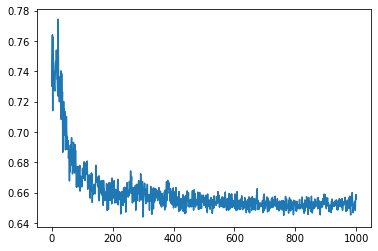

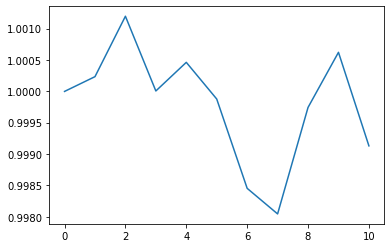


 ### SAVE MODEL ### 

at iter 1010 ELBO loss metric 0.6521468162536621
at iter 1020 ELBO loss metric 0.6509100198745728
at iter 1030 ELBO loss metric 0.6465563774108887
at iter 1040 ELBO loss metric 0.6523000597953796
at iter 1050 ELBO loss metric 0.6541351675987244
at iter 1060 ELBO loss metric 0.6492974162101746
at iter 1070 ELBO loss metric 0.6545819044113159
at iter 1080 ELBO loss metric 0.6516889333724976
at iter 1090 ELBO loss metric 0.6501976251602173
at iter 1100 ELBO loss metric 0.6494980454444885

 ldj check 0.997882068157196 

at iter 1110 ELBO loss metric 0.6539547443389893
at iter 1120 ELBO loss metric 0.6541986465454102
at iter 1130 ELBO loss metric 0.6505479216575623
at iter 1140 ELBO loss metric 0.6524645090103149
at iter 1150 ELBO loss metric 0.651186466217041
at iter 1160 ELBO loss metric 0.6520684957504272
at iter 1170 ELBO loss metric 0.6450756192207336
at iter 1180 ELBO loss metric 0.6489982604980469
at iter 1190 ELBO loss metric 0.6527974009513855
at iter 1200 EL

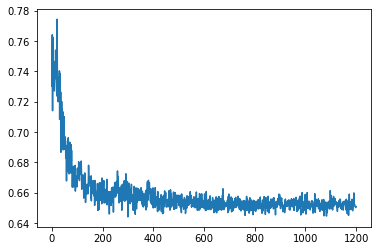

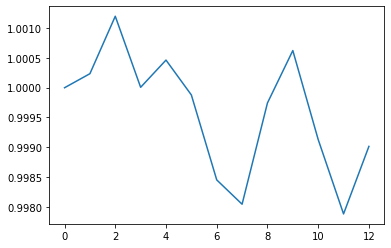


 ### SAVE MODEL ### 

at iter 1210 ELBO loss metric 0.6528183817863464
at iter 1220 ELBO loss metric 0.6498500108718872
at iter 1230 ELBO loss metric 0.6524723768234253
at iter 1240 ELBO loss metric 0.647138237953186
at iter 1250 ELBO loss metric 0.6502707004547119
at iter 1260 ELBO loss metric 0.6558334827423096
at iter 1270 ELBO loss metric 0.6468661427497864
at iter 1280 ELBO loss metric 0.6541961431503296
at iter 1290 ELBO loss metric 0.6509717702865601
at iter 1300 ELBO loss metric 0.653148889541626

 ldj check 1.001273274421692 

at iter 1310 ELBO loss metric 0.6516133546829224
at iter 1320 ELBO loss metric 0.6522572040557861
at iter 1330 ELBO loss metric 0.6563808917999268
at iter 1340 ELBO loss metric 0.6502014398574829
at iter 1350 ELBO loss metric 0.6506048440933228
at iter 1360 ELBO loss metric 0.6457279324531555
at iter 1370 ELBO loss metric 0.6549353003501892
at iter 1380 ELBO loss metric 0.6554676294326782
at iter 1390 ELBO loss metric 0.6533074378967285
at iter 1400 ELB

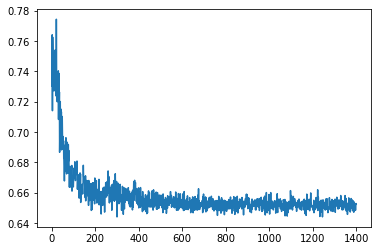

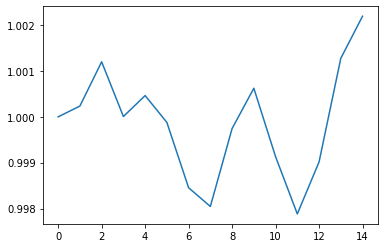


 ### SAVE MODEL ### 

at iter 1410 ELBO loss metric 0.6473636031150818
at iter 1420 ELBO loss metric 0.6492889523506165
at iter 1430 ELBO loss metric 0.6505643129348755
at iter 1440 ELBO loss metric 0.6509937644004822
at iter 1450 ELBO loss metric 0.6486594676971436
at iter 1460 ELBO loss metric 0.6535247564315796
at iter 1470 ELBO loss metric 0.6543734073638916
at iter 1480 ELBO loss metric 0.6522027254104614
at iter 1490 ELBO loss metric 0.650291919708252
at iter 1500 ELBO loss metric 0.651465892791748

 ldj check 1.0029376745224 

at iter 1510 ELBO loss metric 0.659113347530365
at iter 1520 ELBO loss metric 0.6505548357963562
at iter 1530 ELBO loss metric 0.6502593755722046
at iter 1540 ELBO loss metric 0.6498919725418091
at iter 1550 ELBO loss metric 0.6546244621276855
at iter 1560 ELBO loss metric 0.6537567377090454
at iter 1570 ELBO loss metric 0.6511367559432983
at iter 1580 ELBO loss metric 0.6501222848892212
at iter 1590 ELBO loss metric 0.6481869220733643
at iter 1600 ELBO l

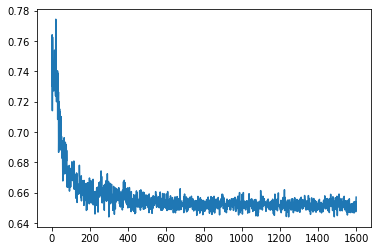

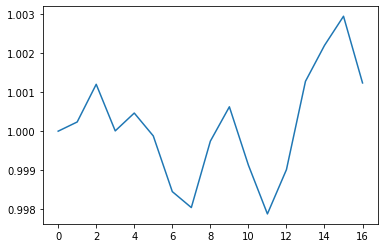


 ### SAVE MODEL ### 

at iter 1610 ELBO loss metric 0.6513669490814209
at iter 1620 ELBO loss metric 0.6530081033706665
at iter 1630 ELBO loss metric 0.6504799723625183
at iter 1640 ELBO loss metric 0.6518301367759705
at iter 1650 ELBO loss metric 0.6505621671676636
at iter 1660 ELBO loss metric 0.6505927443504333
at iter 1670 ELBO loss metric 0.6543735861778259
at iter 1680 ELBO loss metric 0.655695378780365
at iter 1690 ELBO loss metric 0.6551027297973633
at iter 1700 ELBO loss metric 0.6469191312789917

 ldj check 1.0002957582473755 

at iter 1710 ELBO loss metric 0.652556836605072
at iter 1720 ELBO loss metric 0.6509171724319458
at iter 1730 ELBO loss metric 0.6515312194824219
at iter 1740 ELBO loss metric 0.6522632837295532
at iter 1750 ELBO loss metric 0.6484755277633667
at iter 1760 ELBO loss metric 0.6526565551757812
at iter 1770 ELBO loss metric 0.6523734927177429
at iter 1780 ELBO loss metric 0.6512798070907593
at iter 1790 ELBO loss metric 0.6560395956039429
at iter 1800 EL

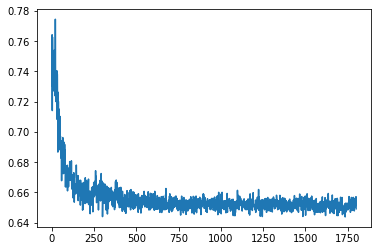

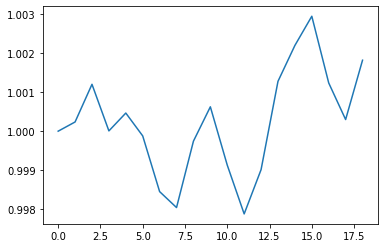


 ### SAVE MODEL ### 

at iter 1810 ELBO loss metric 0.6496777534484863
at iter 1820 ELBO loss metric 0.6495661735534668
at iter 1830 ELBO loss metric 0.6546257734298706
at iter 1840 ELBO loss metric 0.6490049362182617
at iter 1850 ELBO loss metric 0.6536954641342163
at iter 1860 ELBO loss metric 0.6488717794418335
at iter 1870 ELBO loss metric 0.6491713523864746
at iter 1880 ELBO loss metric 0.6509922742843628
at iter 1890 ELBO loss metric 0.6498709917068481
at iter 1900 ELBO loss metric 0.6486397385597229

 ldj check 0.9965623021125793 

at iter 1910 ELBO loss metric 0.6523571014404297
at iter 1920 ELBO loss metric 0.647545576095581
at iter 1930 ELBO loss metric 0.6513335704803467
at iter 1940 ELBO loss metric 0.6490715146064758
at iter 1950 ELBO loss metric 0.6498438119888306
at iter 1960 ELBO loss metric 0.6504923105239868
at iter 1970 ELBO loss metric 0.6538509130477905
at iter 1980 ELBO loss metric 0.6498136520385742
at iter 1990 ELBO loss metric 0.6493178606033325

run 1 with se

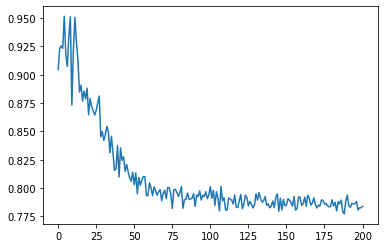

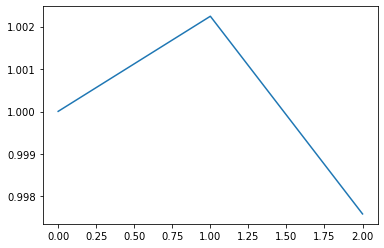


 ### SAVE MODEL ### 

at iter 210 ELBO loss metric 0.7883042097091675
at iter 220 ELBO loss metric 0.7837645411491394
at iter 230 ELBO loss metric 0.7824093103408813
at iter 240 ELBO loss metric 0.7878245115280151
at iter 250 ELBO loss metric 0.7843824625015259
at iter 260 ELBO loss metric 0.7872976660728455
at iter 270 ELBO loss metric 0.7850738167762756
at iter 280 ELBO loss metric 0.7807072401046753
at iter 290 ELBO loss metric 0.7785857319831848
at iter 300 ELBO loss metric 0.7931517362594604

 ldj check 1.000104308128357 

at iter 310 ELBO loss metric 0.7815612554550171
at iter 320 ELBO loss metric 0.7865135669708252
at iter 330 ELBO loss metric 0.7827914357185364
at iter 340 ELBO loss metric 0.7794719934463501
at iter 350 ELBO loss metric 0.7853584289550781
at iter 360 ELBO loss metric 0.7795320153236389
at iter 370 ELBO loss metric 0.780214786529541
at iter 380 ELBO loss metric 0.7781241536140442
at iter 390 ELBO loss metric 0.7848050594329834
at iter 400 ELBO loss metric 0.785

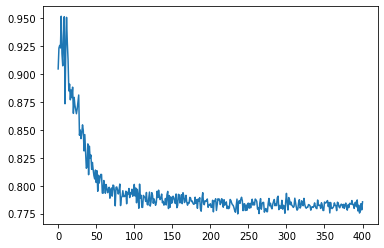

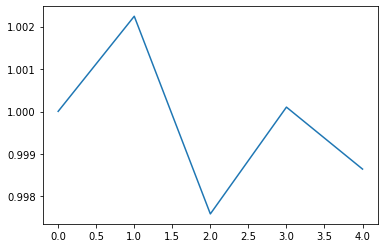


 ### SAVE MODEL ### 

at iter 410 ELBO loss metric 0.7816268801689148
at iter 420 ELBO loss metric 0.7858726978302002
at iter 430 ELBO loss metric 0.7812098264694214
at iter 440 ELBO loss metric 0.7823415398597717
at iter 450 ELBO loss metric 0.783122181892395
at iter 460 ELBO loss metric 0.7733839750289917
at iter 470 ELBO loss metric 0.7779641151428223
at iter 480 ELBO loss metric 0.7831789255142212
at iter 490 ELBO loss metric 0.783742368221283
at iter 500 ELBO loss metric 0.7821205854415894

 ldj check 1.002388834953308 

at iter 510 ELBO loss metric 0.7824686765670776
at iter 520 ELBO loss metric 0.7823392152786255
at iter 530 ELBO loss metric 0.7862038612365723
at iter 540 ELBO loss metric 0.7858510613441467
at iter 550 ELBO loss metric 0.7807288765907288
at iter 560 ELBO loss metric 0.7838071584701538
at iter 570 ELBO loss metric 0.7775219678878784
at iter 580 ELBO loss metric 0.7830188274383545
at iter 590 ELBO loss metric 0.7792055606842041
at iter 600 ELBO loss metric 0.7849

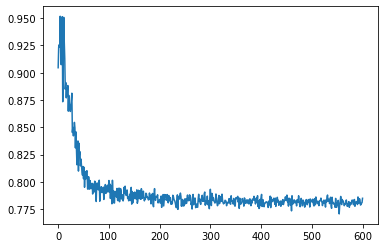

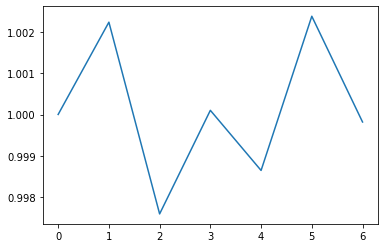


 ### SAVE MODEL ### 

at iter 610 ELBO loss metric 0.7797501087188721
at iter 620 ELBO loss metric 0.7826191782951355
at iter 630 ELBO loss metric 0.7863549590110779
at iter 640 ELBO loss metric 0.7820793390274048
at iter 650 ELBO loss metric 0.7826164960861206
at iter 660 ELBO loss metric 0.7803843021392822
at iter 670 ELBO loss metric 0.7817999124526978
at iter 680 ELBO loss metric 0.7783432006835938
at iter 690 ELBO loss metric 0.7807270288467407
at iter 700 ELBO loss metric 0.7789729833602905

 ldj check 0.9990646839141846 

at iter 710 ELBO loss metric 0.7817441821098328
at iter 720 ELBO loss metric 0.7824642658233643
at iter 730 ELBO loss metric 0.7802238464355469
at iter 740 ELBO loss metric 0.7825157046318054
at iter 750 ELBO loss metric 0.7792512774467468
at iter 760 ELBO loss metric 0.7866069078445435
at iter 770 ELBO loss metric 0.7821839451789856
at iter 780 ELBO loss metric 0.776272177696228
at iter 790 ELBO loss metric 0.7783399820327759
at iter 800 ELBO loss metric 0.78

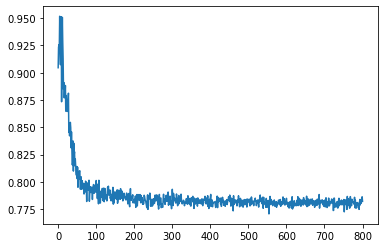

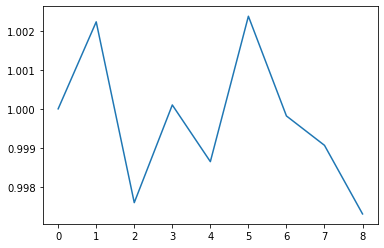


 ### SAVE MODEL ### 

at iter 810 ELBO loss metric 0.7768189907073975
at iter 820 ELBO loss metric 0.7797209620475769
at iter 830 ELBO loss metric 0.7832276225090027
at iter 840 ELBO loss metric 0.7804938554763794
at iter 850 ELBO loss metric 0.779384970664978
at iter 860 ELBO loss metric 0.7823656797409058
at iter 870 ELBO loss metric 0.7788404822349548
at iter 880 ELBO loss metric 0.7799520492553711
at iter 890 ELBO loss metric 0.7812933921813965
at iter 900 ELBO loss metric 0.7804367542266846

 ldj check 1.001386046409607 

at iter 910 ELBO loss metric 0.7827515602111816
at iter 920 ELBO loss metric 0.7805107235908508
at iter 930 ELBO loss metric 0.7803975343704224
at iter 940 ELBO loss metric 0.7830824255943298
at iter 950 ELBO loss metric 0.7771285772323608
at iter 960 ELBO loss metric 0.7778984308242798
at iter 970 ELBO loss metric 0.7787520885467529
at iter 980 ELBO loss metric 0.7806075811386108
at iter 990 ELBO loss metric 0.783877432346344
at iter 1000 ELBO loss metric 0.781

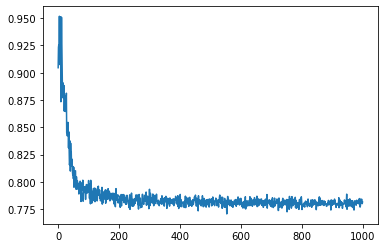

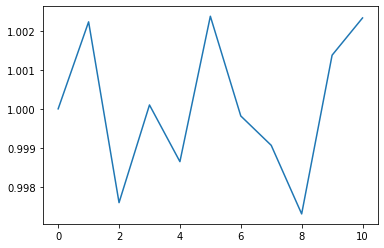


 ### SAVE MODEL ### 

at iter 1010 ELBO loss metric 0.7806358933448792
at iter 1020 ELBO loss metric 0.7798528671264648
at iter 1030 ELBO loss metric 0.7834411859512329
at iter 1040 ELBO loss metric 0.7782597541809082
at iter 1050 ELBO loss metric 0.7758147120475769
at iter 1060 ELBO loss metric 0.7735427618026733
at iter 1070 ELBO loss metric 0.77850741147995
at iter 1080 ELBO loss metric 0.7808578014373779
at iter 1090 ELBO loss metric 0.7812712788581848
at iter 1100 ELBO loss metric 0.7768570184707642

 ldj check 1.0012562274932861 

at iter 1110 ELBO loss metric 0.7822563052177429
at iter 1120 ELBO loss metric 0.7804638147354126
at iter 1130 ELBO loss metric 0.7832434773445129
at iter 1140 ELBO loss metric 0.7786921858787537
at iter 1150 ELBO loss metric 0.7777522206306458
at iter 1160 ELBO loss metric 0.7830733060836792
at iter 1170 ELBO loss metric 0.7774244546890259
at iter 1180 ELBO loss metric 0.7785909175872803
at iter 1190 ELBO loss metric 0.7805120944976807
at iter 1200 EL

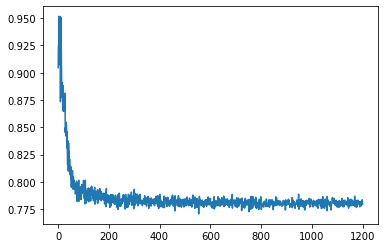

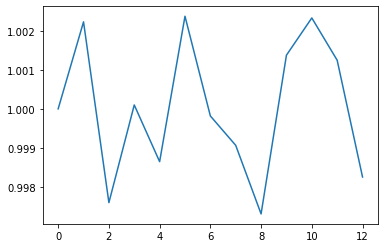


 ### SAVE MODEL ### 

at iter 1210 ELBO loss metric 0.7800356149673462
at iter 1220 ELBO loss metric 0.7805271148681641
at iter 1230 ELBO loss metric 0.7818402647972107
at iter 1240 ELBO loss metric 0.7799667716026306
at iter 1250 ELBO loss metric 0.7793512940406799
at iter 1260 ELBO loss metric 0.7804734706878662
at iter 1270 ELBO loss metric 0.7814767360687256
at iter 1280 ELBO loss metric 0.7763959169387817
at iter 1290 ELBO loss metric 0.7762928009033203
at iter 1300 ELBO loss metric 0.7808809280395508

 ldj check 1.0008842945098877 

at iter 1310 ELBO loss metric 0.7802858352661133
at iter 1320 ELBO loss metric 0.7763179540634155
at iter 1330 ELBO loss metric 0.7841105461120605
at iter 1340 ELBO loss metric 0.7799984216690063
at iter 1350 ELBO loss metric 0.7775622606277466
at iter 1360 ELBO loss metric 0.7811073064804077
at iter 1370 ELBO loss metric 0.7805245518684387
at iter 1380 ELBO loss metric 0.7845004796981812
at iter 1390 ELBO loss metric 0.7789162397384644
at iter 1400 

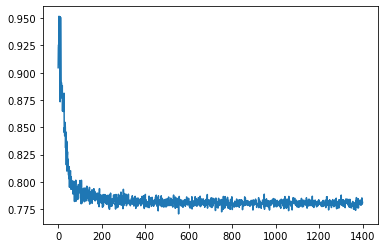

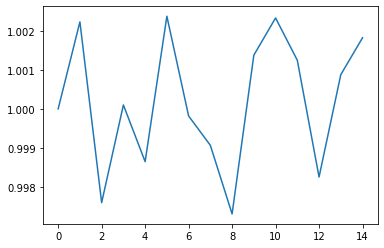


 ### SAVE MODEL ### 

at iter 1410 ELBO loss metric 0.7796519994735718
at iter 1420 ELBO loss metric 0.7768946886062622
at iter 1430 ELBO loss metric 0.7800246477127075
at iter 1440 ELBO loss metric 0.7809848785400391
at iter 1450 ELBO loss metric 0.7785459756851196
at iter 1460 ELBO loss metric 0.7806139588356018
at iter 1470 ELBO loss metric 0.782752513885498
at iter 1480 ELBO loss metric 0.7846678495407104
at iter 1490 ELBO loss metric 0.7834099531173706
at iter 1500 ELBO loss metric 0.7752832770347595

 ldj check 1.0003068447113037 

at iter 1510 ELBO loss metric 0.7817845940589905
at iter 1520 ELBO loss metric 0.7791491746902466
at iter 1530 ELBO loss metric 0.7827933430671692
at iter 1540 ELBO loss metric 0.7827093601226807
at iter 1550 ELBO loss metric 0.7796288132667542
at iter 1560 ELBO loss metric 0.7859319448471069
at iter 1570 ELBO loss metric 0.7777139544487
at iter 1580 ELBO loss metric 0.7764803171157837
at iter 1590 ELBO loss metric 0.7750241756439209
at iter 1600 ELBO

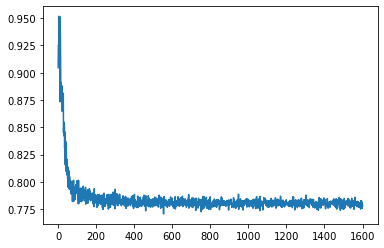

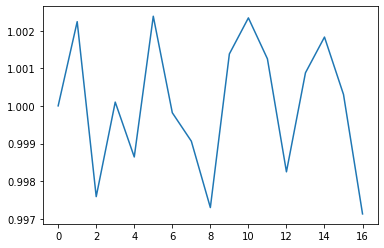


 ### SAVE MODEL ### 

at iter 1610 ELBO loss metric 0.7798948287963867
at iter 1620 ELBO loss metric 0.7786806225776672
at iter 1630 ELBO loss metric 0.7764369249343872
at iter 1640 ELBO loss metric 0.7770758867263794
at iter 1650 ELBO loss metric 0.7795916795730591
at iter 1660 ELBO loss metric 0.7780519723892212
at iter 1670 ELBO loss metric 0.7792377471923828
at iter 1680 ELBO loss metric 0.7834597826004028
at iter 1690 ELBO loss metric 0.7759431600570679
at iter 1700 ELBO loss metric 0.7798771858215332

 ldj check 1.0023236274719238 

at iter 1710 ELBO loss metric 0.7815977334976196
at iter 1720 ELBO loss metric 0.7812721729278564
at iter 1730 ELBO loss metric 0.779125452041626
at iter 1740 ELBO loss metric 0.7836042642593384
at iter 1750 ELBO loss metric 0.7818000316619873
at iter 1760 ELBO loss metric 0.7849634885787964
at iter 1770 ELBO loss metric 0.7813817858695984
at iter 1780 ELBO loss metric 0.7774434089660645
at iter 1790 ELBO loss metric 0.7783576846122742
at iter 1800 E

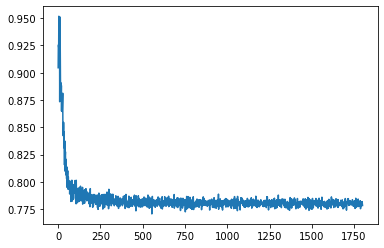

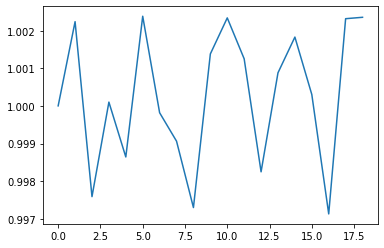


 ### SAVE MODEL ### 

at iter 1810 ELBO loss metric 0.7793004512786865
at iter 1820 ELBO loss metric 0.7779028415679932
at iter 1830 ELBO loss metric 0.7813608050346375
at iter 1840 ELBO loss metric 0.7760483026504517
at iter 1850 ELBO loss metric 0.7812695503234863
at iter 1860 ELBO loss metric 0.7782421708106995
at iter 1870 ELBO loss metric 0.7777896523475647
at iter 1880 ELBO loss metric 0.7839221954345703
at iter 1890 ELBO loss metric 0.7835851907730103
at iter 1900 ELBO loss metric 0.777464747428894

 ldj check 1.0018033981323242 

at iter 1910 ELBO loss metric 0.7799088954925537
at iter 1920 ELBO loss metric 0.7745376229286194
at iter 1930 ELBO loss metric 0.7783844470977783
at iter 1940 ELBO loss metric 0.7829514145851135
at iter 1950 ELBO loss metric 0.7806689739227295
at iter 1960 ELBO loss metric 0.784136176109314
at iter 1970 ELBO loss metric 0.7826430201530457
at iter 1980 ELBO loss metric 0.7781664729118347
at iter 1990 ELBO loss metric 0.7780768871307373
at iter 0 ELBO 

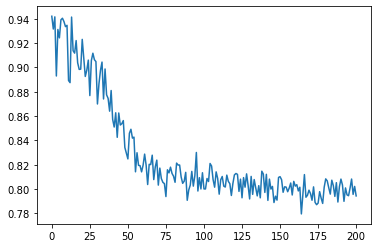

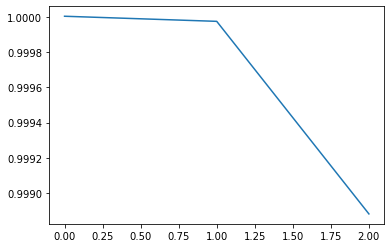


 ### SAVE MODEL ### 

at iter 210 ELBO loss metric 0.7948944568634033
at iter 220 ELBO loss metric 0.8030731081962585
at iter 230 ELBO loss metric 0.7959181666374207
at iter 240 ELBO loss metric 0.7824482321739197
at iter 250 ELBO loss metric 0.800335705280304
at iter 260 ELBO loss metric 0.7927229404449463
at iter 270 ELBO loss metric 0.786901593208313
at iter 280 ELBO loss metric 0.7948044538497925
at iter 290 ELBO loss metric 0.7938314080238342
at iter 300 ELBO loss metric 0.7916516065597534

 ldj check 0.9987214803695679 

at iter 310 ELBO loss metric 0.7844929695129395
at iter 320 ELBO loss metric 0.7850555181503296
at iter 330 ELBO loss metric 0.7897849082946777
at iter 340 ELBO loss metric 0.7917894124984741
at iter 350 ELBO loss metric 0.7915544509887695
at iter 360 ELBO loss metric 0.7886347770690918
at iter 370 ELBO loss metric 0.7902301549911499
at iter 380 ELBO loss metric 0.7844020128250122
at iter 390 ELBO loss metric 0.793566107749939
at iter 400 ELBO loss metric 0.7898

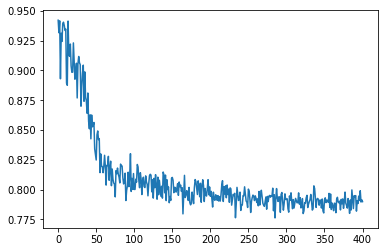

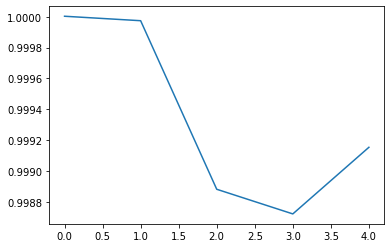


 ### SAVE MODEL ### 

at iter 410 ELBO loss metric 0.7822338342666626
at iter 420 ELBO loss metric 0.7750040292739868
at iter 430 ELBO loss metric 0.7885323762893677
at iter 440 ELBO loss metric 0.7847037315368652
at iter 450 ELBO loss metric 0.7889678478240967
at iter 460 ELBO loss metric 0.7928982973098755
at iter 470 ELBO loss metric 0.7907278537750244
at iter 480 ELBO loss metric 0.7822631001472473
at iter 490 ELBO loss metric 0.7858131527900696
at iter 500 ELBO loss metric 0.7858352661132812

 ldj check 0.9999485611915588 

at iter 510 ELBO loss metric 0.7926477193832397
at iter 520 ELBO loss metric 0.7815302014350891
at iter 530 ELBO loss metric 0.7938345670700073
at iter 540 ELBO loss metric 0.7867592573165894
at iter 550 ELBO loss metric 0.7888116836547852
at iter 560 ELBO loss metric 0.7889444828033447
at iter 570 ELBO loss metric 0.7883201837539673
at iter 580 ELBO loss metric 0.7815561294555664
at iter 590 ELBO loss metric 0.796803891658783
at iter 600 ELBO loss metric 0.79

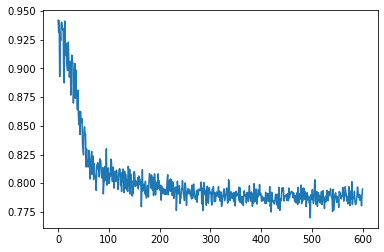

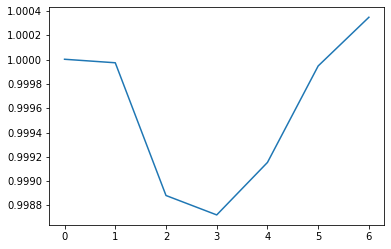


 ### SAVE MODEL ### 

at iter 610 ELBO loss metric 0.7875580191612244
at iter 620 ELBO loss metric 0.794247567653656
at iter 630 ELBO loss metric 0.7895486354827881
at iter 640 ELBO loss metric 0.7913092374801636
at iter 650 ELBO loss metric 0.7854818105697632
at iter 660 ELBO loss metric 0.7858408689498901
at iter 670 ELBO loss metric 0.7863773107528687
at iter 680 ELBO loss metric 0.7875909805297852
at iter 690 ELBO loss metric 0.783735990524292
at iter 700 ELBO loss metric 0.7820833921432495

 ldj check 1.0003052949905396 

at iter 710 ELBO loss metric 0.7826084494590759
at iter 720 ELBO loss metric 0.7884471416473389
at iter 730 ELBO loss metric 0.7885823845863342
at iter 740 ELBO loss metric 0.7804484963417053
at iter 750 ELBO loss metric 0.7921648621559143
at iter 760 ELBO loss metric 0.7836293578147888
at iter 770 ELBO loss metric 0.790690004825592
at iter 780 ELBO loss metric 0.7865620851516724
at iter 790 ELBO loss metric 0.7802367806434631
at iter 800 ELBO loss metric 0.7919

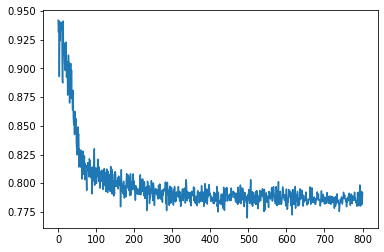

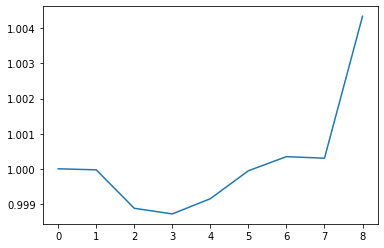


 ### SAVE MODEL ### 

at iter 810 ELBO loss metric 0.7857732772827148
at iter 820 ELBO loss metric 0.78236985206604
at iter 830 ELBO loss metric 0.7835238575935364
at iter 840 ELBO loss metric 0.7843225598335266
at iter 850 ELBO loss metric 0.779754638671875
at iter 860 ELBO loss metric 0.7904022932052612
at iter 870 ELBO loss metric 0.7857344746589661
at iter 880 ELBO loss metric 0.7795384526252747
at iter 890 ELBO loss metric 0.793708086013794
at iter 900 ELBO loss metric 0.7841161489486694

 ldj check 0.9996873736381531 

at iter 910 ELBO loss metric 0.7845609188079834
at iter 920 ELBO loss metric 0.7866142988204956
at iter 930 ELBO loss metric 0.7767509818077087
at iter 940 ELBO loss metric 0.7882412672042847
at iter 950 ELBO loss metric 0.7899499535560608
at iter 960 ELBO loss metric 0.786338210105896
at iter 970 ELBO loss metric 0.7823852300643921
at iter 980 ELBO loss metric 0.7915634512901306
at iter 990 ELBO loss metric 0.7930471897125244
at iter 1000 ELBO loss metric 0.78991

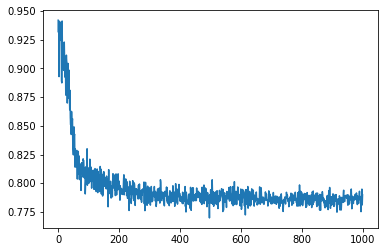

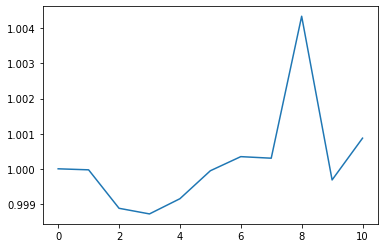


 ### SAVE MODEL ### 

at iter 1010 ELBO loss metric 0.7839867472648621
at iter 1020 ELBO loss metric 0.7808998823165894
at iter 1030 ELBO loss metric 0.785735547542572
at iter 1040 ELBO loss metric 0.7800834774971008
at iter 1050 ELBO loss metric 0.7877919673919678
at iter 1060 ELBO loss metric 0.7882893085479736
at iter 1070 ELBO loss metric 0.7857401371002197
at iter 1080 ELBO loss metric 0.7846042513847351
at iter 1090 ELBO loss metric 0.7774614095687866
at iter 1100 ELBO loss metric 0.7799022793769836

 ldj check 0.9998704195022583 

at iter 1110 ELBO loss metric 0.7868404984474182
at iter 1120 ELBO loss metric 0.7791515588760376
at iter 1130 ELBO loss metric 0.7798975110054016
at iter 1140 ELBO loss metric 0.784764289855957
at iter 1150 ELBO loss metric 0.7875657677650452
at iter 1160 ELBO loss metric 0.7829709053039551
at iter 1170 ELBO loss metric 0.7889566421508789
at iter 1180 ELBO loss metric 0.7906444072723389
at iter 1190 ELBO loss metric 0.7775159478187561
at iter 1200 EL

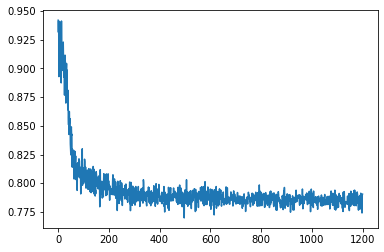

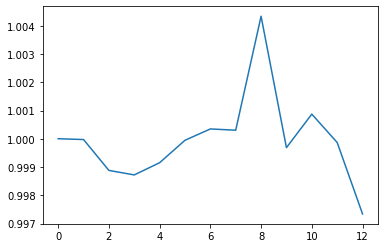


 ### SAVE MODEL ### 

at iter 1210 ELBO loss metric 0.7788083553314209
at iter 1220 ELBO loss metric 0.7933056950569153
at iter 1230 ELBO loss metric 0.7816478610038757
at iter 1240 ELBO loss metric 0.7906176447868347
at iter 1250 ELBO loss metric 0.7849520444869995
at iter 1260 ELBO loss metric 0.7912265062332153
at iter 1270 ELBO loss metric 0.7803673148155212
at iter 1280 ELBO loss metric 0.7810901403427124
at iter 1290 ELBO loss metric 0.7838567495346069
at iter 1300 ELBO loss metric 0.786268949508667

 ldj check 1.000688910484314 

at iter 1310 ELBO loss metric 0.7822391390800476
at iter 1320 ELBO loss metric 0.7865067720413208
at iter 1330 ELBO loss metric 0.7861306667327881
at iter 1340 ELBO loss metric 0.7839099168777466
at iter 1350 ELBO loss metric 0.7873023748397827
at iter 1360 ELBO loss metric 0.7896890044212341
at iter 1370 ELBO loss metric 0.779909610748291
at iter 1380 ELBO loss metric 0.7781638503074646
at iter 1390 ELBO loss metric 0.7813716530799866
at iter 1400 ELB

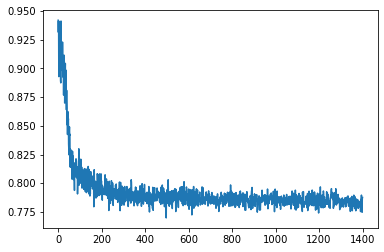

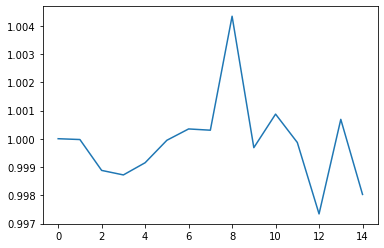


 ### SAVE MODEL ### 

at iter 1410 ELBO loss metric 0.7841492891311646
at iter 1420 ELBO loss metric 0.7866513133049011
at iter 1430 ELBO loss metric 0.7798471450805664
at iter 1440 ELBO loss metric 0.7845500707626343
at iter 1450 ELBO loss metric 0.7858201265335083
at iter 1460 ELBO loss metric 0.786953330039978
at iter 1470 ELBO loss metric 0.777912974357605
at iter 1480 ELBO loss metric 0.7827358841896057
at iter 1490 ELBO loss metric 0.7810500264167786
at iter 1500 ELBO loss metric 0.78103107213974

 ldj check 1.0013034343719482 

at iter 1510 ELBO loss metric 0.7807163596153259
at iter 1520 ELBO loss metric 0.7835673689842224
at iter 1530 ELBO loss metric 0.7824399471282959
at iter 1540 ELBO loss metric 0.7796561121940613
at iter 1550 ELBO loss metric 0.7816683053970337
at iter 1560 ELBO loss metric 0.7821073532104492
at iter 1570 ELBO loss metric 0.7839360237121582
at iter 1580 ELBO loss metric 0.7848418354988098
at iter 1590 ELBO loss metric 0.7792916297912598
at iter 1600 ELBO

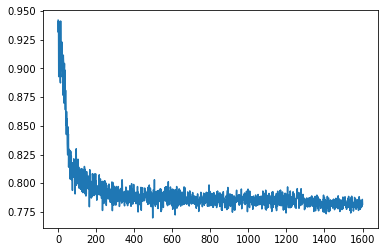

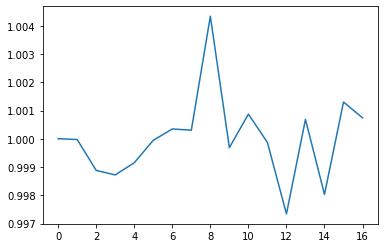


 ### SAVE MODEL ### 

at iter 1610 ELBO loss metric 0.7766954302787781
at iter 1620 ELBO loss metric 0.7808622121810913
at iter 1630 ELBO loss metric 0.7849383354187012
at iter 1640 ELBO loss metric 0.7839298248291016
at iter 1650 ELBO loss metric 0.780586302280426
at iter 1660 ELBO loss metric 0.7874553799629211
at iter 1670 ELBO loss metric 0.7801685929298401
at iter 1680 ELBO loss metric 0.7840520143508911
at iter 1690 ELBO loss metric 0.7860159873962402
at iter 1700 ELBO loss metric 0.783021867275238

 ldj check 0.9993204474449158 

at iter 1710 ELBO loss metric 0.782636284828186
at iter 1720 ELBO loss metric 0.7822583913803101
at iter 1730 ELBO loss metric 0.7822624444961548
at iter 1740 ELBO loss metric 0.7759872674942017
at iter 1750 ELBO loss metric 0.7833774089813232
at iter 1760 ELBO loss metric 0.7798988819122314
at iter 1770 ELBO loss metric 0.7825199365615845
at iter 1780 ELBO loss metric 0.7845171093940735
at iter 1790 ELBO loss metric 0.7803742289543152
at iter 1800 ELB

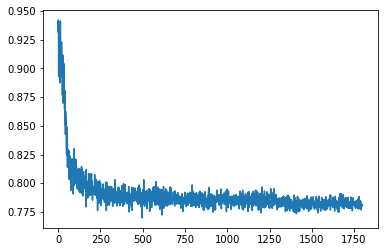

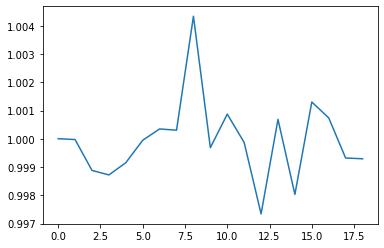


 ### SAVE MODEL ### 

at iter 1810 ELBO loss metric 0.7826942801475525
at iter 1820 ELBO loss metric 0.7731150388717651
at iter 1830 ELBO loss metric 0.7824883460998535
at iter 1840 ELBO loss metric 0.7822040915489197
at iter 1850 ELBO loss metric 0.7807126045227051
at iter 1860 ELBO loss metric 0.7924410104751587
at iter 1870 ELBO loss metric 0.7814631462097168
at iter 1880 ELBO loss metric 0.787807047367096
at iter 1890 ELBO loss metric 0.7794765830039978
at iter 1900 ELBO loss metric 0.7781342267990112

 ldj check 0.9993048310279846 

at iter 1910 ELBO loss metric 0.7812432646751404
at iter 1920 ELBO loss metric 0.7782577872276306
at iter 1930 ELBO loss metric 0.7819837331771851
at iter 1940 ELBO loss metric 0.7868468165397644
at iter 1950 ELBO loss metric 0.7806034088134766
at iter 1960 ELBO loss metric 0.7844618558883667
at iter 1970 ELBO loss metric 0.7798407077789307
at iter 1980 ELBO loss metric 0.7787572145462036
at iter 1990 ELBO loss metric 0.7775201797485352

run 2 with se

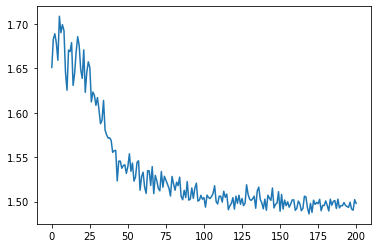

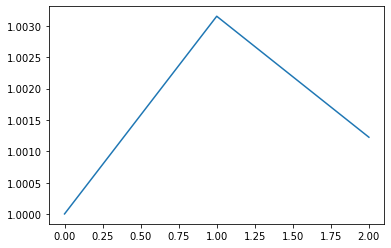


 ### SAVE MODEL ### 

at iter 210 ELBO loss metric 1.4928300380706787
at iter 220 ELBO loss metric 1.487006425857544
at iter 230 ELBO loss metric 1.4892897605895996
at iter 240 ELBO loss metric 1.4877021312713623
at iter 250 ELBO loss metric 1.489966630935669
at iter 260 ELBO loss metric 1.4947625398635864
at iter 270 ELBO loss metric 1.4954304695129395
at iter 280 ELBO loss metric 1.4887421131134033
at iter 290 ELBO loss metric 1.4778916835784912
at iter 300 ELBO loss metric 1.491334319114685

 ldj check 0.999935507774353 

at iter 310 ELBO loss metric 1.484297752380371
at iter 320 ELBO loss metric 1.4860458374023438
at iter 330 ELBO loss metric 1.4855107069015503
at iter 340 ELBO loss metric 1.4811980724334717
at iter 350 ELBO loss metric 1.4848730564117432
at iter 360 ELBO loss metric 1.4891523122787476
at iter 370 ELBO loss metric 1.4857386350631714
at iter 380 ELBO loss metric 1.489760398864746
at iter 390 ELBO loss metric 1.4779744148254395
at iter 400 ELBO loss metric 1.4866750

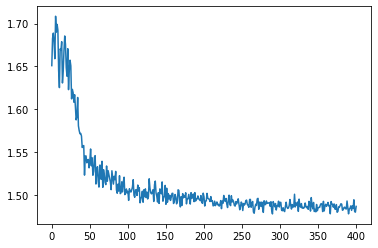

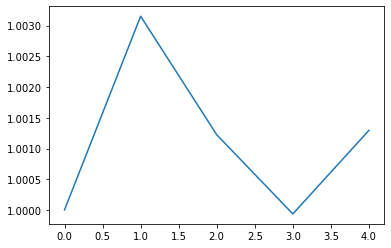


 ### SAVE MODEL ### 

at iter 410 ELBO loss metric 1.478200912475586
at iter 420 ELBO loss metric 1.4845540523529053
at iter 430 ELBO loss metric 1.4827053546905518
at iter 440 ELBO loss metric 1.4821059703826904
at iter 450 ELBO loss metric 1.487410306930542
at iter 460 ELBO loss metric 1.4882529973983765
at iter 470 ELBO loss metric 1.4911034107208252
at iter 480 ELBO loss metric 1.4857736825942993
at iter 490 ELBO loss metric 1.481200933456421
at iter 500 ELBO loss metric 1.4816911220550537

 ldj check 1.0006121397018433 

at iter 510 ELBO loss metric 1.4848034381866455
at iter 520 ELBO loss metric 1.4879101514816284
at iter 530 ELBO loss metric 1.4848415851593018
at iter 540 ELBO loss metric 1.4821642637252808
at iter 550 ELBO loss metric 1.4815199375152588
at iter 560 ELBO loss metric 1.4877493381500244
at iter 570 ELBO loss metric 1.4883935451507568
at iter 580 ELBO loss metric 1.4861845970153809
at iter 590 ELBO loss metric 1.491269826889038
at iter 600 ELBO loss metric 1.47644

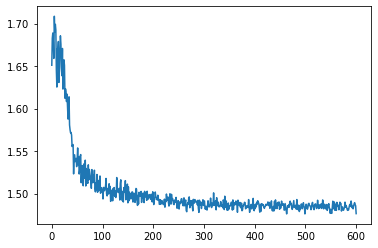

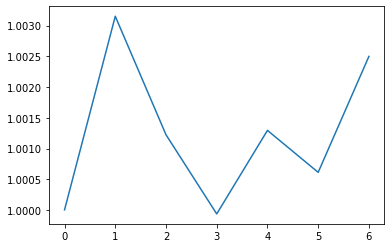


 ### SAVE MODEL ### 

at iter 610 ELBO loss metric 1.489253044128418
at iter 620 ELBO loss metric 1.4842705726623535
at iter 630 ELBO loss metric 1.4899113178253174
at iter 640 ELBO loss metric 1.488893747329712
at iter 650 ELBO loss metric 1.4848432540893555
at iter 660 ELBO loss metric 1.4899251461029053
at iter 670 ELBO loss metric 1.483780026435852
at iter 680 ELBO loss metric 1.4869861602783203
at iter 690 ELBO loss metric 1.4787589311599731
at iter 700 ELBO loss metric 1.4900782108306885

 ldj check 0.9990728497505188 

at iter 710 ELBO loss metric 1.4778809547424316
at iter 720 ELBO loss metric 1.4827114343643188
at iter 730 ELBO loss metric 1.4913560152053833
at iter 740 ELBO loss metric 1.4846527576446533
at iter 750 ELBO loss metric 1.4831678867340088
at iter 760 ELBO loss metric 1.4798352718353271
at iter 770 ELBO loss metric 1.4852293729782104
at iter 780 ELBO loss metric 1.480743408203125
at iter 790 ELBO loss metric 1.4812407493591309
at iter 800 ELBO loss metric 1.48408

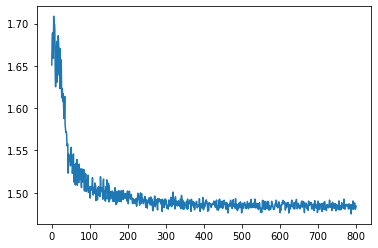

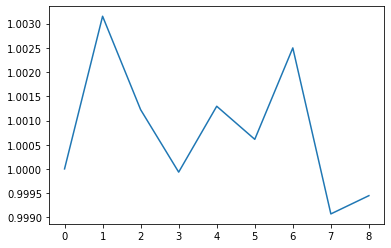


 ### SAVE MODEL ### 

at iter 810 ELBO loss metric 1.4817183017730713
at iter 820 ELBO loss metric 1.4836232662200928
at iter 830 ELBO loss metric 1.4842184782028198
at iter 840 ELBO loss metric 1.4866328239440918
at iter 850 ELBO loss metric 1.4813721179962158
at iter 860 ELBO loss metric 1.4861526489257812
at iter 870 ELBO loss metric 1.4849416017532349
at iter 880 ELBO loss metric 1.4823875427246094
at iter 890 ELBO loss metric 1.4847607612609863
at iter 900 ELBO loss metric 1.4878367185592651

 ldj check 0.9993025660514832 

at iter 910 ELBO loss metric 1.4892120361328125
at iter 920 ELBO loss metric 1.488548994064331
at iter 930 ELBO loss metric 1.4809118509292603
at iter 940 ELBO loss metric 1.4835866689682007
at iter 950 ELBO loss metric 1.481569528579712
at iter 960 ELBO loss metric 1.4810705184936523
at iter 970 ELBO loss metric 1.4834885597229004
at iter 980 ELBO loss metric 1.4794220924377441
at iter 990 ELBO loss metric 1.4867572784423828
at iter 1000 ELBO loss metric 1.48

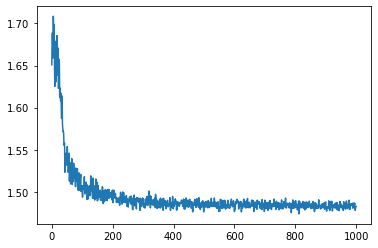

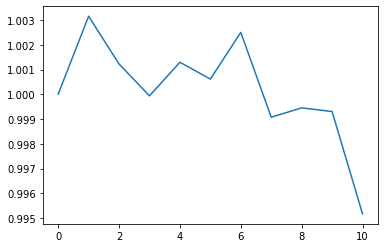


 ### SAVE MODEL ### 

at iter 1010 ELBO loss metric 1.4798846244812012
at iter 1020 ELBO loss metric 1.485211968421936
at iter 1030 ELBO loss metric 1.4811924695968628
at iter 1040 ELBO loss metric 1.4817010164260864
at iter 1050 ELBO loss metric 1.4800004959106445
at iter 1060 ELBO loss metric 1.4833147525787354
at iter 1070 ELBO loss metric 1.489251971244812
at iter 1080 ELBO loss metric 1.4821131229400635
at iter 1090 ELBO loss metric 1.484002947807312
at iter 1100 ELBO loss metric 1.4859042167663574

 ldj check 1.0029419660568237 

at iter 1110 ELBO loss metric 1.47986900806427
at iter 1120 ELBO loss metric 1.4811136722564697
at iter 1130 ELBO loss metric 1.4856292009353638
at iter 1140 ELBO loss metric 1.4841116666793823
at iter 1150 ELBO loss metric 1.482865333557129
at iter 1160 ELBO loss metric 1.4866297245025635
at iter 1170 ELBO loss metric 1.486665964126587
at iter 1180 ELBO loss metric 1.477557897567749
at iter 1190 ELBO loss metric 1.484354019165039
at iter 1200 ELBO loss

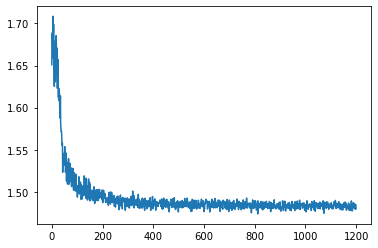

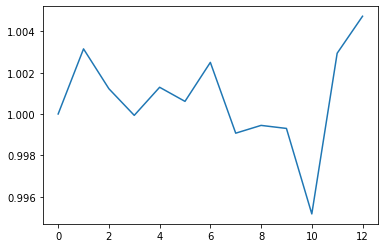


 ### SAVE MODEL ### 

at iter 1210 ELBO loss metric 1.4844067096710205
at iter 1220 ELBO loss metric 1.4824321269989014
at iter 1230 ELBO loss metric 1.4846785068511963
at iter 1240 ELBO loss metric 1.4850714206695557
at iter 1250 ELBO loss metric 1.483156442642212
at iter 1260 ELBO loss metric 1.4860858917236328
at iter 1270 ELBO loss metric 1.4810463190078735
at iter 1280 ELBO loss metric 1.4801414012908936
at iter 1290 ELBO loss metric 1.4828366041183472
at iter 1300 ELBO loss metric 1.488353967666626

 ldj check 0.999590277671814 

at iter 1310 ELBO loss metric 1.482146978378296
at iter 1320 ELBO loss metric 1.4794087409973145
at iter 1330 ELBO loss metric 1.4817535877227783
at iter 1340 ELBO loss metric 1.4855990409851074
at iter 1350 ELBO loss metric 1.4865679740905762
at iter 1360 ELBO loss metric 1.4868953227996826
at iter 1370 ELBO loss metric 1.4796730279922485
at iter 1380 ELBO loss metric 1.482295036315918
at iter 1390 ELBO loss metric 1.4845845699310303
at iter 1400 ELBO 

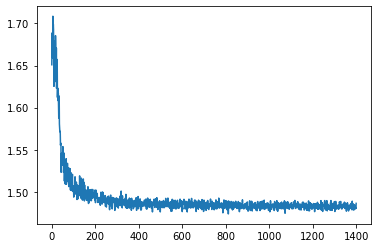

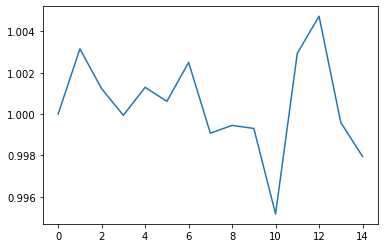


 ### SAVE MODEL ### 

at iter 1410 ELBO loss metric 1.4827542304992676
at iter 1420 ELBO loss metric 1.4830456972122192
at iter 1430 ELBO loss metric 1.4793620109558105
at iter 1440 ELBO loss metric 1.4758604764938354
at iter 1450 ELBO loss metric 1.4844958782196045
at iter 1460 ELBO loss metric 1.477183222770691
at iter 1470 ELBO loss metric 1.4813261032104492
at iter 1480 ELBO loss metric 1.476647973060608
at iter 1490 ELBO loss metric 1.4786920547485352
at iter 1500 ELBO loss metric 1.4831602573394775

 ldj check 0.9982883930206299 

at iter 1510 ELBO loss metric 1.4868934154510498
at iter 1520 ELBO loss metric 1.4826985597610474
at iter 1530 ELBO loss metric 1.4804301261901855
at iter 1540 ELBO loss metric 1.4845428466796875
at iter 1550 ELBO loss metric 1.482914924621582
at iter 1560 ELBO loss metric 1.4821518659591675
at iter 1570 ELBO loss metric 1.4862738847732544
at iter 1580 ELBO loss metric 1.4822700023651123
at iter 1590 ELBO loss metric 1.4817845821380615
at iter 1600 ELB

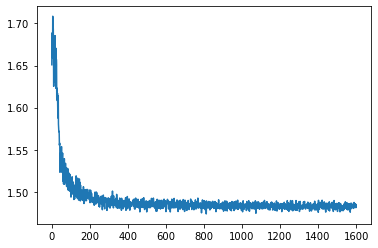

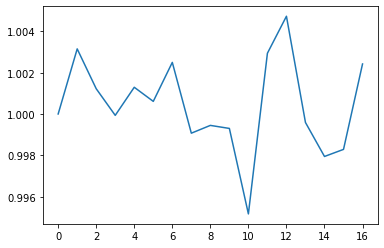


 ### SAVE MODEL ### 

at iter 1610 ELBO loss metric 1.4828089475631714
at iter 1620 ELBO loss metric 1.4786744117736816
at iter 1630 ELBO loss metric 1.4788665771484375
at iter 1640 ELBO loss metric 1.483656406402588
at iter 1650 ELBO loss metric 1.482513189315796
at iter 1660 ELBO loss metric 1.4788880348205566
at iter 1670 ELBO loss metric 1.4826667308807373
at iter 1680 ELBO loss metric 1.4811017513275146
at iter 1690 ELBO loss metric 1.478729009628296
at iter 1700 ELBO loss metric 1.4844822883605957

 ldj check 0.9957820177078247 

at iter 1710 ELBO loss metric 1.4831018447875977
at iter 1720 ELBO loss metric 1.4851861000061035
at iter 1730 ELBO loss metric 1.479783058166504
at iter 1740 ELBO loss metric 1.4850027561187744
at iter 1750 ELBO loss metric 1.480095386505127
at iter 1760 ELBO loss metric 1.4809465408325195
at iter 1770 ELBO loss metric 1.4819486141204834
at iter 1780 ELBO loss metric 1.4819855690002441
at iter 1790 ELBO loss metric 1.481764316558838
at iter 1800 ELBO l

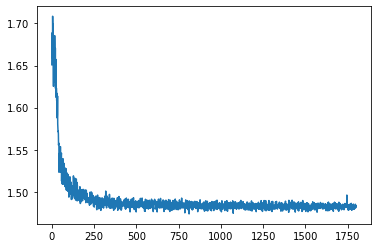

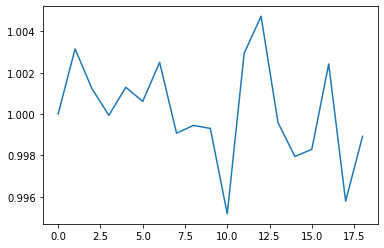


 ### SAVE MODEL ### 

at iter 1810 ELBO loss metric 1.4804354906082153
at iter 1820 ELBO loss metric 1.4817004203796387
at iter 1830 ELBO loss metric 1.481753945350647
at iter 1840 ELBO loss metric 1.4825215339660645
at iter 1850 ELBO loss metric 1.484188437461853
at iter 1860 ELBO loss metric 1.485318660736084
at iter 1870 ELBO loss metric 1.48293137550354
at iter 1880 ELBO loss metric 1.4875984191894531
at iter 1890 ELBO loss metric 1.4826427698135376
at iter 1900 ELBO loss metric 1.4769439697265625

 ldj check 0.999564528465271 

at iter 1910 ELBO loss metric 1.4837017059326172
at iter 1920 ELBO loss metric 1.4818542003631592
at iter 1930 ELBO loss metric 1.4802956581115723
at iter 1940 ELBO loss metric 1.4801406860351562
at iter 1950 ELBO loss metric 1.4846938848495483
at iter 1960 ELBO loss metric 1.476534366607666
at iter 1970 ELBO loss metric 1.481935739517212
at iter 1980 ELBO loss metric 1.4828667640686035
at iter 1990 ELBO loss metric 1.4854435920715332
at iter 0 ELBO loss m

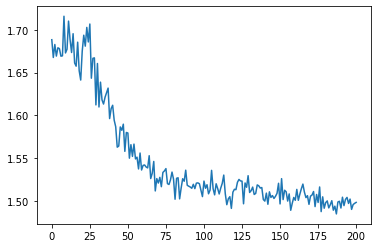

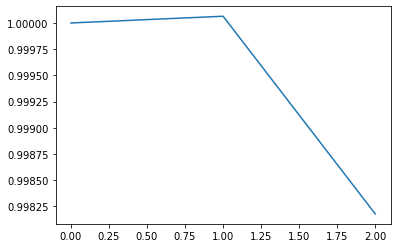


 ### SAVE MODEL ### 

at iter 210 ELBO loss metric 1.4921854734420776
at iter 220 ELBO loss metric 1.488887906074524
at iter 230 ELBO loss metric 1.4955217838287354
at iter 240 ELBO loss metric 1.4946794509887695
at iter 250 ELBO loss metric 1.4917826652526855
at iter 260 ELBO loss metric 1.4970334768295288
at iter 270 ELBO loss metric 1.4911894798278809
at iter 280 ELBO loss metric 1.4909511804580688
at iter 290 ELBO loss metric 1.496574878692627
at iter 300 ELBO loss metric 1.4914507865905762

 ldj check 0.9997838735580444 

at iter 310 ELBO loss metric 1.4838006496429443
at iter 320 ELBO loss metric 1.4877456426620483
at iter 330 ELBO loss metric 1.4902844429016113
at iter 340 ELBO loss metric 1.4899063110351562
at iter 350 ELBO loss metric 1.4893443584442139
at iter 360 ELBO loss metric 1.4866180419921875
at iter 370 ELBO loss metric 1.4866173267364502
at iter 380 ELBO loss metric 1.4822165966033936
at iter 390 ELBO loss metric 1.4947805404663086
at iter 400 ELBO loss metric 1.486

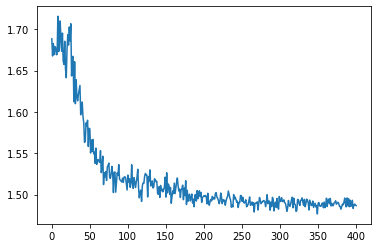

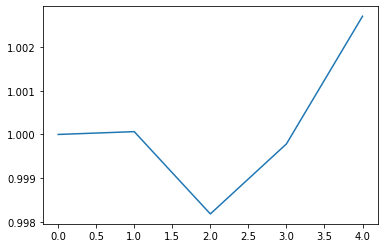


 ### SAVE MODEL ### 

at iter 410 ELBO loss metric 1.4831342697143555
at iter 420 ELBO loss metric 1.4934093952178955
at iter 430 ELBO loss metric 1.4887861013412476
at iter 440 ELBO loss metric 1.4811476469039917
at iter 450 ELBO loss metric 1.4904168844223022
at iter 460 ELBO loss metric 1.4837803840637207
at iter 470 ELBO loss metric 1.482863426208496
at iter 480 ELBO loss metric 1.4842252731323242
at iter 490 ELBO loss metric 1.4855273962020874
at iter 500 ELBO loss metric 1.4808423519134521

 ldj check 0.9972906112670898 

at iter 510 ELBO loss metric 1.489128589630127
at iter 520 ELBO loss metric 1.481964349746704
at iter 530 ELBO loss metric 1.4877040386199951
at iter 540 ELBO loss metric 1.4846117496490479
at iter 550 ELBO loss metric 1.4822192192077637
at iter 560 ELBO loss metric 1.482245922088623
at iter 570 ELBO loss metric 1.4863530397415161
at iter 580 ELBO loss metric 1.4770691394805908
at iter 590 ELBO loss metric 1.4872937202453613
at iter 600 ELBO loss metric 1.48176

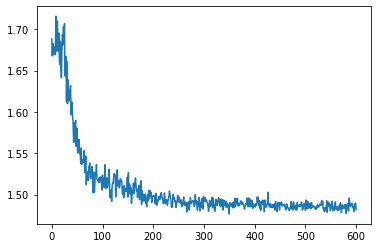

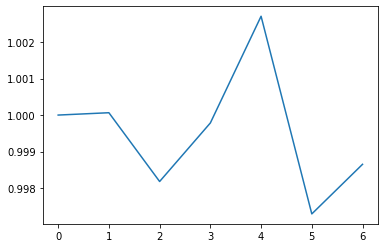


 ### SAVE MODEL ### 

at iter 610 ELBO loss metric 1.4836862087249756
at iter 620 ELBO loss metric 1.4859931468963623
at iter 630 ELBO loss metric 1.4863617420196533
at iter 640 ELBO loss metric 1.486039161682129
at iter 650 ELBO loss metric 1.486783742904663
at iter 660 ELBO loss metric 1.4833910465240479
at iter 670 ELBO loss metric 1.4843000173568726
at iter 680 ELBO loss metric 1.4839460849761963
at iter 690 ELBO loss metric 1.4853341579437256
at iter 700 ELBO loss metric 1.4855258464813232

 ldj check 1.0019739866256714 

at iter 710 ELBO loss metric 1.4880280494689941
at iter 720 ELBO loss metric 1.4806560277938843
at iter 730 ELBO loss metric 1.4800429344177246
at iter 740 ELBO loss metric 1.4818933010101318
at iter 750 ELBO loss metric 1.479465126991272
at iter 760 ELBO loss metric 1.4831902980804443
at iter 770 ELBO loss metric 1.4862267971038818
at iter 780 ELBO loss metric 1.4830729961395264
at iter 790 ELBO loss metric 1.4808454513549805
at iter 800 ELBO loss metric 1.4815

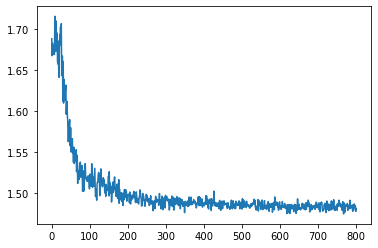

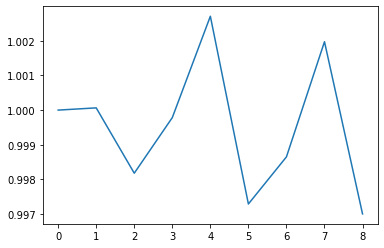


 ### SAVE MODEL ### 

at iter 810 ELBO loss metric 1.4919264316558838
at iter 820 ELBO loss metric 1.486160159111023
at iter 830 ELBO loss metric 1.4836633205413818
at iter 840 ELBO loss metric 1.4823323488235474
at iter 850 ELBO loss metric 1.4806222915649414
at iter 860 ELBO loss metric 1.4814435243606567
at iter 870 ELBO loss metric 1.4867562055587769
at iter 880 ELBO loss metric 1.4897119998931885
at iter 890 ELBO loss metric 1.4874558448791504
at iter 900 ELBO loss metric 1.4880046844482422

 ldj check 1.000159502029419 

at iter 910 ELBO loss metric 1.4830883741378784
at iter 920 ELBO loss metric 1.4833227396011353
at iter 930 ELBO loss metric 1.4836922883987427
at iter 940 ELBO loss metric 1.4830946922302246
at iter 950 ELBO loss metric 1.4835178852081299
at iter 960 ELBO loss metric 1.4862666130065918
at iter 970 ELBO loss metric 1.4804604053497314
at iter 980 ELBO loss metric 1.4803168773651123
at iter 990 ELBO loss metric 1.4811723232269287
at iter 1000 ELBO loss metric 1.48

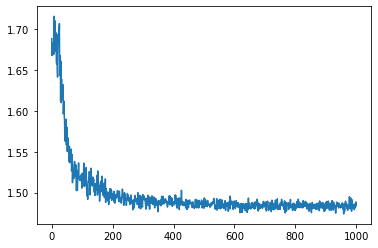

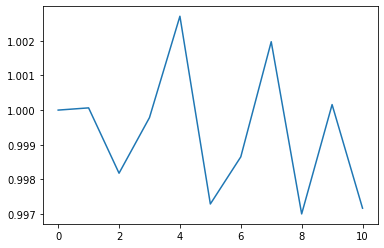


 ### SAVE MODEL ### 

at iter 1010 ELBO loss metric 1.4805548191070557
at iter 1020 ELBO loss metric 1.4854270219802856
at iter 1030 ELBO loss metric 1.4819958209991455
at iter 1040 ELBO loss metric 1.4872417449951172
at iter 1050 ELBO loss metric 1.481997013092041
at iter 1060 ELBO loss metric 1.4793095588684082
at iter 1070 ELBO loss metric 1.4841824769973755
at iter 1080 ELBO loss metric 1.4884791374206543
at iter 1090 ELBO loss metric 1.4865481853485107
at iter 1100 ELBO loss metric 1.4800047874450684

 ldj check 0.9965094327926636 

at iter 1110 ELBO loss metric 1.4819434881210327
at iter 1120 ELBO loss metric 1.4815394878387451
at iter 1130 ELBO loss metric 1.4827579259872437
at iter 1140 ELBO loss metric 1.4872546195983887
at iter 1150 ELBO loss metric 1.479943037033081
at iter 1160 ELBO loss metric 1.4764761924743652
at iter 1170 ELBO loss metric 1.484460473060608
at iter 1180 ELBO loss metric 1.4887292385101318
at iter 1190 ELBO loss metric 1.482983112335205
at iter 1200 ELBO

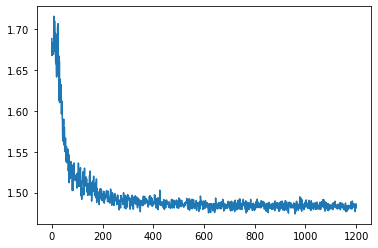

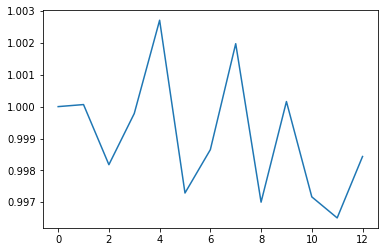


 ### SAVE MODEL ### 

at iter 1210 ELBO loss metric 1.4820218086242676
at iter 1220 ELBO loss metric 1.4829139709472656
at iter 1230 ELBO loss metric 1.4833133220672607
at iter 1240 ELBO loss metric 1.480118751525879
at iter 1250 ELBO loss metric 1.488623023033142
at iter 1260 ELBO loss metric 1.4840970039367676
at iter 1270 ELBO loss metric 1.4817694425582886
at iter 1280 ELBO loss metric 1.480900526046753
at iter 1290 ELBO loss metric 1.482909917831421
at iter 1300 ELBO loss metric 1.4821072816848755

 ldj check 1.0011942386627197 

at iter 1310 ELBO loss metric 1.481269359588623
at iter 1320 ELBO loss metric 1.4854083061218262
at iter 1330 ELBO loss metric 1.4812047481536865
at iter 1340 ELBO loss metric 1.4862966537475586
at iter 1350 ELBO loss metric 1.4839332103729248
at iter 1360 ELBO loss metric 1.481589436531067
at iter 1370 ELBO loss metric 1.4832053184509277
at iter 1380 ELBO loss metric 1.475698471069336
at iter 1390 ELBO loss metric 1.4830081462860107
at iter 1400 ELBO lo

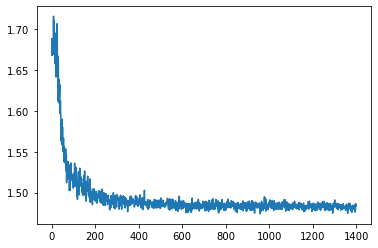

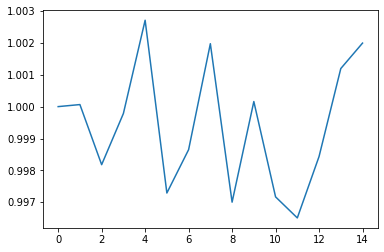


 ### SAVE MODEL ### 

at iter 1410 ELBO loss metric 1.4781755208969116
at iter 1420 ELBO loss metric 1.4829084873199463
at iter 1430 ELBO loss metric 1.4863648414611816
at iter 1440 ELBO loss metric 1.4912309646606445
at iter 1450 ELBO loss metric 1.4852088689804077
at iter 1460 ELBO loss metric 1.4787940979003906
at iter 1470 ELBO loss metric 1.482175350189209
at iter 1480 ELBO loss metric 1.4795234203338623
at iter 1490 ELBO loss metric 1.4773778915405273
at iter 1500 ELBO loss metric 1.4799118041992188

 ldj check 0.9998223185539246 

at iter 1510 ELBO loss metric 1.4827139377593994
at iter 1520 ELBO loss metric 1.482018232345581
at iter 1530 ELBO loss metric 1.483546257019043
at iter 1540 ELBO loss metric 1.4837357997894287
at iter 1550 ELBO loss metric 1.4842567443847656
at iter 1560 ELBO loss metric 1.4846656322479248
at iter 1570 ELBO loss metric 1.4811625480651855
at iter 1580 ELBO loss metric 1.481076955795288
at iter 1590 ELBO loss metric 1.4874963760375977
at iter 1600 ELBO

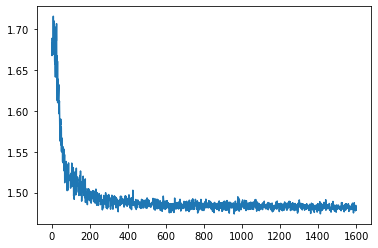

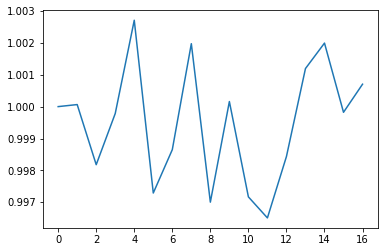


 ### SAVE MODEL ### 

at iter 1610 ELBO loss metric 1.4779314994812012
at iter 1620 ELBO loss metric 1.4784283638000488
at iter 1630 ELBO loss metric 1.4793751239776611
at iter 1640 ELBO loss metric 1.4815059900283813
at iter 1650 ELBO loss metric 1.4828985929489136
at iter 1660 ELBO loss metric 1.4862632751464844
at iter 1670 ELBO loss metric 1.4775770902633667
at iter 1680 ELBO loss metric 1.4796487092971802
at iter 1690 ELBO loss metric 1.4798245429992676
at iter 1700 ELBO loss metric 1.4847323894500732

 ldj check 0.9991728067398071 

at iter 1710 ELBO loss metric 1.4798557758331299
at iter 1720 ELBO loss metric 1.4801855087280273
at iter 1730 ELBO loss metric 1.4817856550216675
at iter 1740 ELBO loss metric 1.4821858406066895
at iter 1750 ELBO loss metric 1.4810585975646973
at iter 1760 ELBO loss metric 1.4827911853790283
at iter 1770 ELBO loss metric 1.480614423751831
at iter 1780 ELBO loss metric 1.4781460762023926
at iter 1790 ELBO loss metric 1.4792102575302124
at iter 1800 E

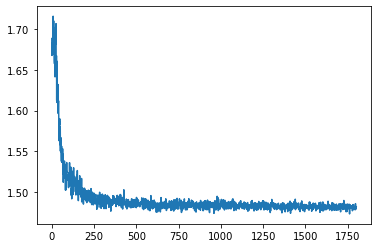

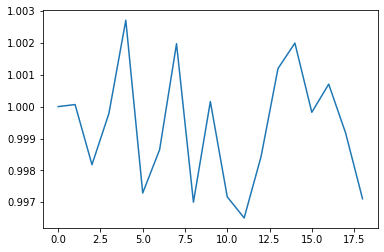


 ### SAVE MODEL ### 

at iter 1810 ELBO loss metric 1.4802850484848022
at iter 1820 ELBO loss metric 1.487026333808899
at iter 1830 ELBO loss metric 1.480268955230713
at iter 1840 ELBO loss metric 1.4810161590576172
at iter 1850 ELBO loss metric 1.4851233959197998
at iter 1860 ELBO loss metric 1.484107255935669
at iter 1870 ELBO loss metric 1.4824109077453613
at iter 1880 ELBO loss metric 1.48687744140625
at iter 1890 ELBO loss metric 1.4822171926498413
at iter 1900 ELBO loss metric 1.4814924001693726

 ldj check 1.001714825630188 

at iter 1910 ELBO loss metric 1.4827908277511597
at iter 1920 ELBO loss metric 1.483091115951538
at iter 1930 ELBO loss metric 1.4814153909683228
at iter 1940 ELBO loss metric 1.4837806224822998
at iter 1950 ELBO loss metric 1.4833192825317383
at iter 1960 ELBO loss metric 1.4780977964401245
at iter 1970 ELBO loss metric 1.481945514678955
at iter 1980 ELBO loss metric 1.4804823398590088
at iter 1990 ELBO loss metric 1.4797577857971191

run 3 with seed 76
d

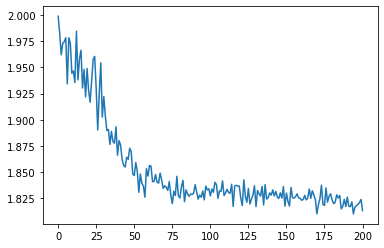

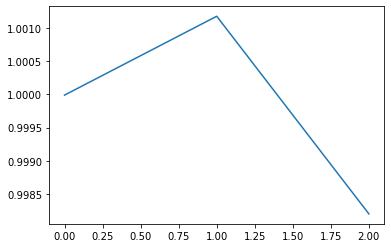


 ### SAVE MODEL ### 

at iter 210 ELBO loss metric 1.8236596584320068
at iter 220 ELBO loss metric 1.8160603046417236
at iter 230 ELBO loss metric 1.8265361785888672
at iter 240 ELBO loss metric 1.8152568340301514
at iter 250 ELBO loss metric 1.8156063556671143
at iter 260 ELBO loss metric 1.8229976892471313
at iter 270 ELBO loss metric 1.8161494731903076
at iter 280 ELBO loss metric 1.8144588470458984
at iter 290 ELBO loss metric 1.8196239471435547
at iter 300 ELBO loss metric 1.8200114965438843

 ldj check 0.997269332408905 

at iter 310 ELBO loss metric 1.8140227794647217
at iter 320 ELBO loss metric 1.823298692703247
at iter 330 ELBO loss metric 1.8088061809539795
at iter 340 ELBO loss metric 1.8118488788604736
at iter 350 ELBO loss metric 1.8106099367141724
at iter 360 ELBO loss metric 1.8218555450439453
at iter 370 ELBO loss metric 1.820199728012085
at iter 380 ELBO loss metric 1.8213269710540771
at iter 390 ELBO loss metric 1.8177440166473389
at iter 400 ELBO loss metric 1.8114

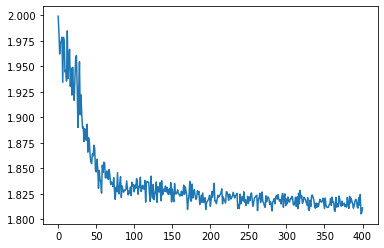

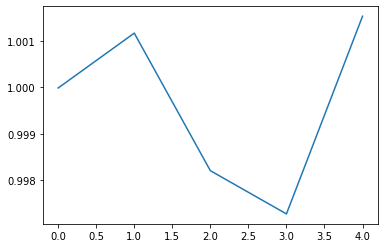


 ### SAVE MODEL ### 

at iter 410 ELBO loss metric 1.8089573383331299
at iter 420 ELBO loss metric 1.8139750957489014
at iter 430 ELBO loss metric 1.8146166801452637
at iter 440 ELBO loss metric 1.8103253841400146
at iter 450 ELBO loss metric 1.818373203277588
at iter 460 ELBO loss metric 1.8112177848815918
at iter 470 ELBO loss metric 1.8139121532440186
at iter 480 ELBO loss metric 1.8081557750701904
at iter 490 ELBO loss metric 1.812294363975525
at iter 500 ELBO loss metric 1.8185088634490967

 ldj check 0.9970887303352356 

at iter 510 ELBO loss metric 1.8132909536361694
at iter 520 ELBO loss metric 1.8167496919631958
at iter 530 ELBO loss metric 1.8126981258392334
at iter 540 ELBO loss metric 1.816514492034912
at iter 550 ELBO loss metric 1.815926432609558
at iter 560 ELBO loss metric 1.8076324462890625
at iter 570 ELBO loss metric 1.8178339004516602
at iter 580 ELBO loss metric 1.808037281036377
at iter 590 ELBO loss metric 1.8156299591064453
at iter 600 ELBO loss metric 1.816170

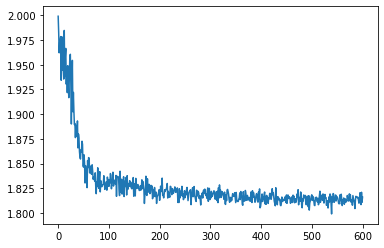

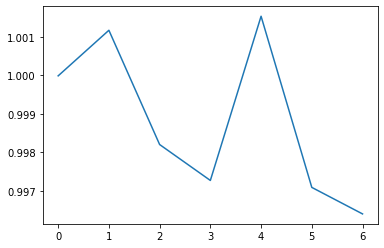


 ### SAVE MODEL ### 

at iter 610 ELBO loss metric 1.8131053447723389
at iter 620 ELBO loss metric 1.8157777786254883
at iter 630 ELBO loss metric 1.8064969778060913
at iter 640 ELBO loss metric 1.812485933303833
at iter 650 ELBO loss metric 1.815610647201538
at iter 660 ELBO loss metric 1.8058364391326904
at iter 670 ELBO loss metric 1.809722900390625
at iter 680 ELBO loss metric 1.8174844980239868
at iter 690 ELBO loss metric 1.8130550384521484
at iter 700 ELBO loss metric 1.8139779567718506

 ldj check 0.999407947063446 

at iter 710 ELBO loss metric 1.815564513206482
at iter 720 ELBO loss metric 1.8100290298461914
at iter 730 ELBO loss metric 1.8131868839263916
at iter 740 ELBO loss metric 1.8116167783737183
at iter 750 ELBO loss metric 1.8091552257537842
at iter 760 ELBO loss metric 1.8094764947891235
at iter 770 ELBO loss metric 1.8047065734863281
at iter 780 ELBO loss metric 1.8120403289794922
at iter 790 ELBO loss metric 1.8092190027236938
at iter 800 ELBO loss metric 1.809773

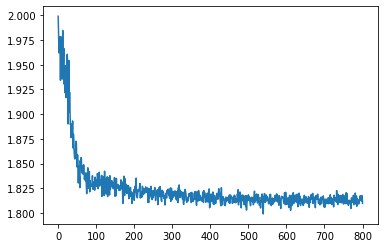

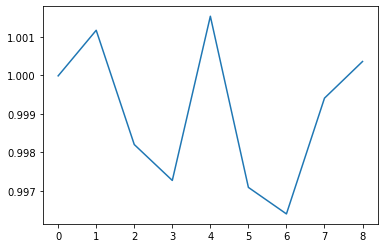


 ### SAVE MODEL ### 

at iter 810 ELBO loss metric 1.8067139387130737
at iter 820 ELBO loss metric 1.8151116371154785
at iter 830 ELBO loss metric 1.8176941871643066
at iter 840 ELBO loss metric 1.8171746730804443
at iter 850 ELBO loss metric 1.80305814743042
at iter 860 ELBO loss metric 1.811335802078247
at iter 870 ELBO loss metric 1.8155250549316406
at iter 880 ELBO loss metric 1.8149162530899048
at iter 890 ELBO loss metric 1.81026291847229
at iter 900 ELBO loss metric 1.8142684698104858

 ldj check 0.9981191754341125 

at iter 910 ELBO loss metric 1.8117647171020508
at iter 920 ELBO loss metric 1.810964584350586
at iter 930 ELBO loss metric 1.8114384412765503
at iter 940 ELBO loss metric 1.8151214122772217
at iter 950 ELBO loss metric 1.8178848028182983
at iter 960 ELBO loss metric 1.8091484308242798
at iter 970 ELBO loss metric 1.8188109397888184
at iter 980 ELBO loss metric 1.8035825490951538
at iter 990 ELBO loss metric 1.8046536445617676
at iter 1000 ELBO loss metric 1.812328

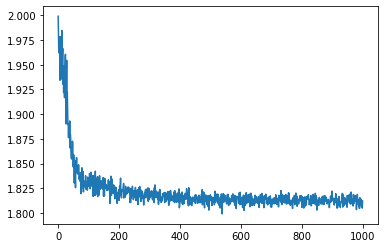

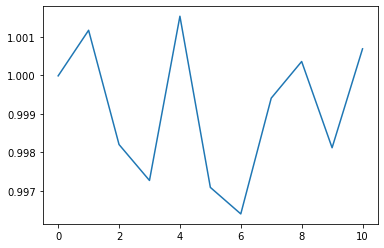


 ### SAVE MODEL ### 

at iter 1010 ELBO loss metric 1.8116227388381958
at iter 1020 ELBO loss metric 1.8075077533721924
at iter 1030 ELBO loss metric 1.8169795274734497
at iter 1040 ELBO loss metric 1.809950590133667
at iter 1050 ELBO loss metric 1.8109196424484253
at iter 1060 ELBO loss metric 1.8145414590835571
at iter 1070 ELBO loss metric 1.8143812417984009
at iter 1080 ELBO loss metric 1.8098132610321045
at iter 1090 ELBO loss metric 1.810790777206421
at iter 1100 ELBO loss metric 1.812913179397583

 ldj check 1.0000141859054565 

at iter 1110 ELBO loss metric 1.8125793933868408
at iter 1120 ELBO loss metric 1.8067476749420166
at iter 1130 ELBO loss metric 1.8192470073699951
at iter 1140 ELBO loss metric 1.809531569480896
at iter 1150 ELBO loss metric 1.8134050369262695
at iter 1160 ELBO loss metric 1.8159337043762207
at iter 1170 ELBO loss metric 1.80975341796875
at iter 1180 ELBO loss metric 1.813827395439148
at iter 1190 ELBO loss metric 1.8132402896881104
at iter 1200 ELBO lo

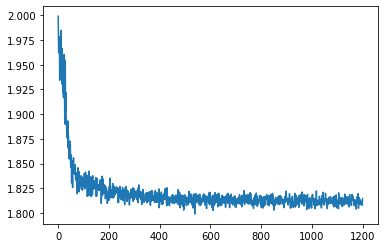

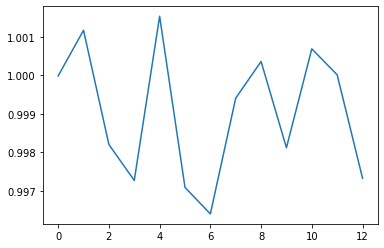


 ### SAVE MODEL ### 

at iter 1210 ELBO loss metric 1.8073031902313232
at iter 1220 ELBO loss metric 1.8108608722686768
at iter 1230 ELBO loss metric 1.814371943473816
at iter 1240 ELBO loss metric 1.8125863075256348
at iter 1250 ELBO loss metric 1.8115971088409424
at iter 1260 ELBO loss metric 1.8069193363189697
at iter 1270 ELBO loss metric 1.8128273487091064
at iter 1280 ELBO loss metric 1.8057482242584229
at iter 1290 ELBO loss metric 1.8129442930221558
at iter 1300 ELBO loss metric 1.8114571571350098

 ldj check 1.0012445449829102 

at iter 1310 ELBO loss metric 1.8171662092208862
at iter 1320 ELBO loss metric 1.8096096515655518
at iter 1330 ELBO loss metric 1.8096418380737305
at iter 1340 ELBO loss metric 1.8147826194763184
at iter 1350 ELBO loss metric 1.8126912117004395
at iter 1360 ELBO loss metric 1.8123912811279297
at iter 1370 ELBO loss metric 1.8119618892669678
at iter 1380 ELBO loss metric 1.80967116355896
at iter 1390 ELBO loss metric 1.816662311553955
at iter 1400 ELBO

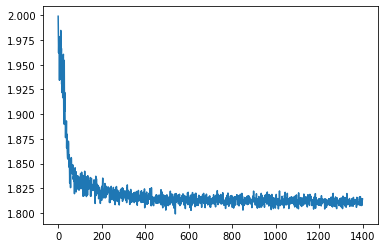

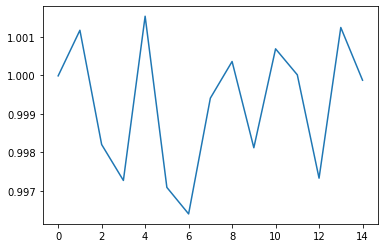


 ### SAVE MODEL ### 

at iter 1410 ELBO loss metric 1.80951726436615
at iter 1420 ELBO loss metric 1.811293601989746
at iter 1430 ELBO loss metric 1.807192087173462
at iter 1440 ELBO loss metric 1.8148220777511597
at iter 1450 ELBO loss metric 1.8097870349884033
at iter 1460 ELBO loss metric 1.811647891998291
at iter 1470 ELBO loss metric 1.805778980255127
at iter 1480 ELBO loss metric 1.8056385517120361
at iter 1490 ELBO loss metric 1.8121341466903687
at iter 1500 ELBO loss metric 1.815765380859375

 ldj check 1.0001351833343506 

at iter 1510 ELBO loss metric 1.8168494701385498
at iter 1520 ELBO loss metric 1.8086163997650146
at iter 1530 ELBO loss metric 1.8106215000152588
at iter 1540 ELBO loss metric 1.8166091442108154
at iter 1550 ELBO loss metric 1.808051586151123
at iter 1560 ELBO loss metric 1.8145558834075928
at iter 1570 ELBO loss metric 1.8140945434570312
at iter 1580 ELBO loss metric 1.8133957386016846
at iter 1590 ELBO loss metric 1.808754801750183
at iter 1600 ELBO loss

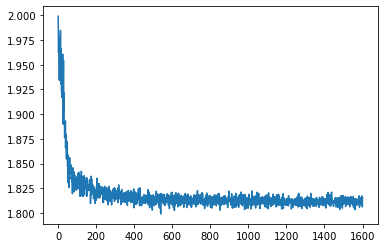

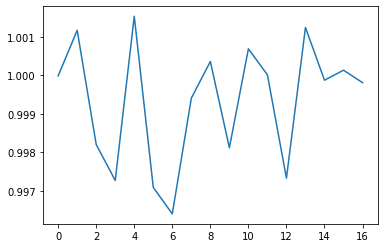


 ### SAVE MODEL ### 

at iter 1610 ELBO loss metric 1.815854549407959
at iter 1620 ELBO loss metric 1.8079105615615845
at iter 1630 ELBO loss metric 1.8155701160430908
at iter 1640 ELBO loss metric 1.8086929321289062
at iter 1650 ELBO loss metric 1.8108514547348022
at iter 1660 ELBO loss metric 1.8081387281417847
at iter 1670 ELBO loss metric 1.8103294372558594
at iter 1680 ELBO loss metric 1.8112397193908691
at iter 1690 ELBO loss metric 1.8061331510543823
at iter 1700 ELBO loss metric 1.8129678964614868

 ldj check 1.0014312267303467 

at iter 1710 ELBO loss metric 1.8061480522155762
at iter 1720 ELBO loss metric 1.8088610172271729
at iter 1730 ELBO loss metric 1.8092706203460693
at iter 1740 ELBO loss metric 1.809168815612793
at iter 1750 ELBO loss metric 1.8206605911254883
at iter 1760 ELBO loss metric 1.8090434074401855
at iter 1770 ELBO loss metric 1.8117740154266357
at iter 1780 ELBO loss metric 1.8131016492843628
at iter 1790 ELBO loss metric 1.8074009418487549
at iter 1800 EL

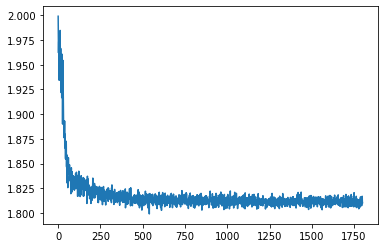

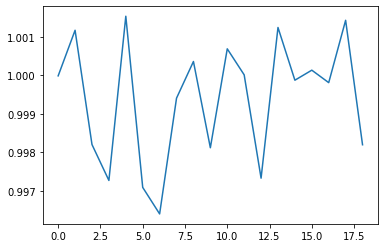


 ### SAVE MODEL ### 

at iter 1810 ELBO loss metric 1.8097097873687744
at iter 1820 ELBO loss metric 1.812164545059204
at iter 1830 ELBO loss metric 1.809556007385254
at iter 1840 ELBO loss metric 1.8120052814483643
at iter 1850 ELBO loss metric 1.8144950866699219
at iter 1860 ELBO loss metric 1.8162686824798584
at iter 1870 ELBO loss metric 1.8111546039581299
at iter 1880 ELBO loss metric 1.8167362213134766
at iter 1890 ELBO loss metric 1.8104422092437744
at iter 1900 ELBO loss metric 1.8077374696731567

 ldj check 0.9986774921417236 

at iter 1910 ELBO loss metric 1.8131139278411865
at iter 1920 ELBO loss metric 1.8132318258285522
at iter 1930 ELBO loss metric 1.8125207424163818
at iter 1940 ELBO loss metric 1.815014362335205
at iter 1950 ELBO loss metric 1.8083442449569702
at iter 1960 ELBO loss metric 1.812880039215088
at iter 1970 ELBO loss metric 1.8107880353927612
at iter 1980 ELBO loss metric 1.8142180442810059
at iter 1990 ELBO loss metric 1.81011962890625
at iter 0 ELBO loss

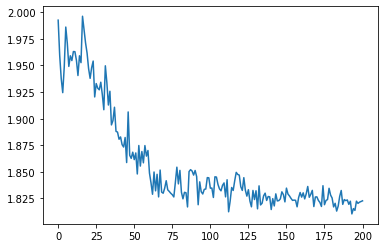

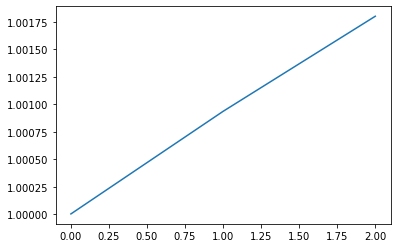


 ### SAVE MODEL ### 

at iter 210 ELBO loss metric 1.8118705749511719
at iter 220 ELBO loss metric 1.8206846714019775
at iter 230 ELBO loss metric 1.813028335571289
at iter 240 ELBO loss metric 1.8223447799682617
at iter 250 ELBO loss metric 1.8278727531433105
at iter 260 ELBO loss metric 1.8185566663742065
at iter 270 ELBO loss metric 1.8217886686325073
at iter 280 ELBO loss metric 1.8211593627929688
at iter 290 ELBO loss metric 1.8369479179382324
at iter 300 ELBO loss metric 1.8251065015792847

 ldj check 0.9985721111297607 

at iter 310 ELBO loss metric 1.8157446384429932
at iter 320 ELBO loss metric 1.8156657218933105
at iter 330 ELBO loss metric 1.8223352432250977
at iter 340 ELBO loss metric 1.817343831062317
at iter 350 ELBO loss metric 1.8145726919174194
at iter 360 ELBO loss metric 1.8233976364135742
at iter 370 ELBO loss metric 1.811788558959961
at iter 380 ELBO loss metric 1.812211275100708
at iter 390 ELBO loss metric 1.8171072006225586
at iter 400 ELBO loss metric 1.81455

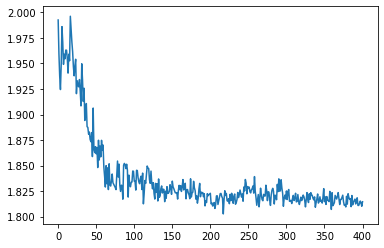

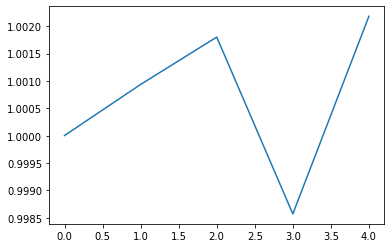


 ### SAVE MODEL ### 

at iter 410 ELBO loss metric 1.8113677501678467
at iter 420 ELBO loss metric 1.8184373378753662
at iter 430 ELBO loss metric 1.8164706230163574
at iter 440 ELBO loss metric 1.8101518154144287
at iter 450 ELBO loss metric 1.8120354413986206
at iter 460 ELBO loss metric 1.820148229598999
at iter 470 ELBO loss metric 1.8136461973190308
at iter 480 ELBO loss metric 1.8110506534576416
at iter 490 ELBO loss metric 1.8133370876312256
at iter 500 ELBO loss metric 1.8181746006011963

 ldj check 1.0009360313415527 

at iter 510 ELBO loss metric 1.8079569339752197
at iter 520 ELBO loss metric 1.8131351470947266
at iter 530 ELBO loss metric 1.8094418048858643
at iter 540 ELBO loss metric 1.8069337606430054
at iter 550 ELBO loss metric 1.8103394508361816
at iter 560 ELBO loss metric 1.8077257871627808
at iter 570 ELBO loss metric 1.8116371631622314
at iter 580 ELBO loss metric 1.8149641752243042
at iter 590 ELBO loss metric 1.811208724975586
at iter 600 ELBO loss metric 1.810

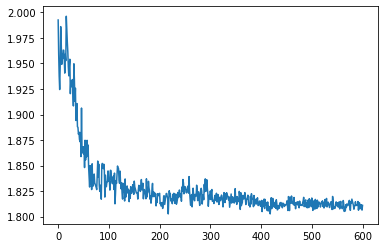

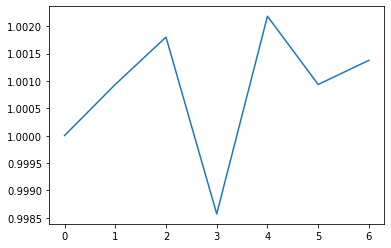


 ### SAVE MODEL ### 

at iter 610 ELBO loss metric 1.8103671073913574
at iter 620 ELBO loss metric 1.8090035915374756
at iter 630 ELBO loss metric 1.8121503591537476
at iter 640 ELBO loss metric 1.810178279876709
at iter 650 ELBO loss metric 1.8134303092956543
at iter 660 ELBO loss metric 1.8117870092391968
at iter 670 ELBO loss metric 1.8143174648284912
at iter 680 ELBO loss metric 1.8082797527313232
at iter 690 ELBO loss metric 1.8069047927856445
at iter 700 ELBO loss metric 1.8133597373962402

 ldj check 0.9993425607681274 

at iter 710 ELBO loss metric 1.8121974468231201
at iter 720 ELBO loss metric 1.8071906566619873
at iter 730 ELBO loss metric 1.8098735809326172
at iter 740 ELBO loss metric 1.807584524154663
at iter 750 ELBO loss metric 1.8126392364501953
at iter 760 ELBO loss metric 1.8154022693634033
at iter 770 ELBO loss metric 1.8115947246551514
at iter 780 ELBO loss metric 1.8168220520019531
at iter 790 ELBO loss metric 1.811410665512085
at iter 800 ELBO loss metric 1.8096

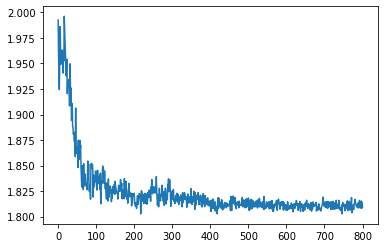

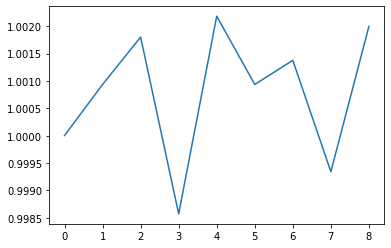


 ### SAVE MODEL ### 

at iter 810 ELBO loss metric 1.8064136505126953
at iter 820 ELBO loss metric 1.8127002716064453
at iter 830 ELBO loss metric 1.8170256614685059
at iter 840 ELBO loss metric 1.8133480548858643
at iter 850 ELBO loss metric 1.8126931190490723
at iter 860 ELBO loss metric 1.8091979026794434
at iter 870 ELBO loss metric 1.8097584247589111
at iter 880 ELBO loss metric 1.8113658428192139
at iter 890 ELBO loss metric 1.8083808422088623
at iter 900 ELBO loss metric 1.811604380607605

 ldj check 1.0016833543777466 

at iter 910 ELBO loss metric 1.8086028099060059
at iter 920 ELBO loss metric 1.8084827661514282
at iter 930 ELBO loss metric 1.8119975328445435
at iter 940 ELBO loss metric 1.8037716150283813
at iter 950 ELBO loss metric 1.8068935871124268
at iter 960 ELBO loss metric 1.8071311712265015
at iter 970 ELBO loss metric 1.8076571226119995
at iter 980 ELBO loss metric 1.8088037967681885
at iter 990 ELBO loss metric 1.8135617971420288
at iter 1000 ELBO loss metric 1.8

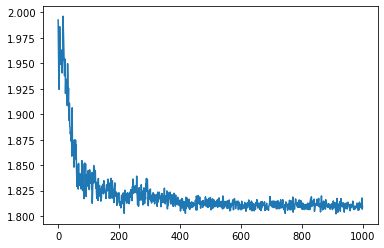

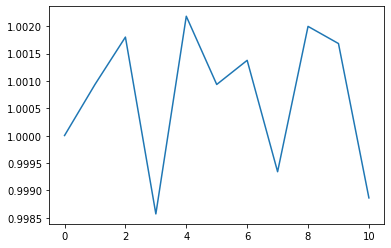


 ### SAVE MODEL ### 

at iter 1010 ELBO loss metric 1.8085076808929443
at iter 1020 ELBO loss metric 1.8054144382476807
at iter 1030 ELBO loss metric 1.8084642887115479
at iter 1040 ELBO loss metric 1.8113824129104614
at iter 1050 ELBO loss metric 1.8080193996429443
at iter 1060 ELBO loss metric 1.8094265460968018
at iter 1070 ELBO loss metric 1.810232400894165
at iter 1080 ELBO loss metric 1.80824613571167
at iter 1090 ELBO loss metric 1.813166856765747
at iter 1100 ELBO loss metric 1.8087207078933716

 ldj check 1.003684163093567 

at iter 1110 ELBO loss metric 1.8116202354431152
at iter 1120 ELBO loss metric 1.8115514516830444
at iter 1130 ELBO loss metric 1.8100706338882446
at iter 1140 ELBO loss metric 1.8097975254058838
at iter 1150 ELBO loss metric 1.8106775283813477
at iter 1160 ELBO loss metric 1.8059744834899902
at iter 1170 ELBO loss metric 1.811495304107666
at iter 1180 ELBO loss metric 1.8060851097106934
at iter 1190 ELBO loss metric 1.8068430423736572
at iter 1200 ELBO l

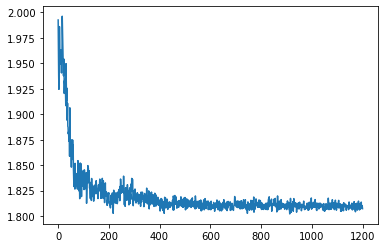

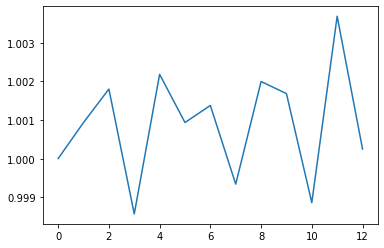


 ### SAVE MODEL ### 

at iter 1210 ELBO loss metric 1.8102267980575562
at iter 1220 ELBO loss metric 1.8127789497375488
at iter 1230 ELBO loss metric 1.804761528968811
at iter 1240 ELBO loss metric 1.8117960691452026
at iter 1250 ELBO loss metric 1.8131113052368164
at iter 1260 ELBO loss metric 1.808302640914917
at iter 1270 ELBO loss metric 1.8055613040924072
at iter 1280 ELBO loss metric 1.8100404739379883
at iter 1290 ELBO loss metric 1.8074939250946045
at iter 1300 ELBO loss metric 1.8093169927597046

 ldj check 1.0025720596313477 

at iter 1310 ELBO loss metric 1.8079172372817993
at iter 1320 ELBO loss metric 1.8090286254882812
at iter 1330 ELBO loss metric 1.8097792863845825
at iter 1340 ELBO loss metric 1.8089832067489624
at iter 1350 ELBO loss metric 1.810991883277893
at iter 1360 ELBO loss metric 1.8057124614715576
at iter 1370 ELBO loss metric 1.805889368057251
at iter 1380 ELBO loss metric 1.8097920417785645
at iter 1390 ELBO loss metric 1.8120622634887695
at iter 1400 ELBO

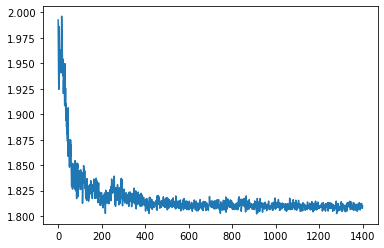

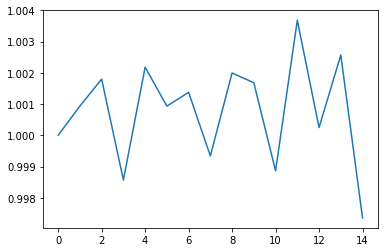


 ### SAVE MODEL ### 

at iter 1410 ELBO loss metric 1.80885648727417
at iter 1420 ELBO loss metric 1.8125371932983398
at iter 1430 ELBO loss metric 1.8073060512542725
at iter 1440 ELBO loss metric 1.810467004776001
at iter 1450 ELBO loss metric 1.8079431056976318
at iter 1460 ELBO loss metric 1.8061429262161255
at iter 1470 ELBO loss metric 1.8108187913894653
at iter 1480 ELBO loss metric 1.8123351335525513
at iter 1490 ELBO loss metric 1.8077352046966553
at iter 1500 ELBO loss metric 1.809790849685669

 ldj check 1.0013375282287598 

at iter 1510 ELBO loss metric 1.805192470550537
at iter 1520 ELBO loss metric 1.8084936141967773
at iter 1530 ELBO loss metric 1.81498384475708
at iter 1540 ELBO loss metric 1.8093643188476562
at iter 1550 ELBO loss metric 1.8129605054855347
at iter 1560 ELBO loss metric 1.8101993799209595
at iter 1570 ELBO loss metric 1.8122472763061523
at iter 1580 ELBO loss metric 1.814328908920288
at iter 1590 ELBO loss metric 1.8166252374649048
at iter 1600 ELBO los

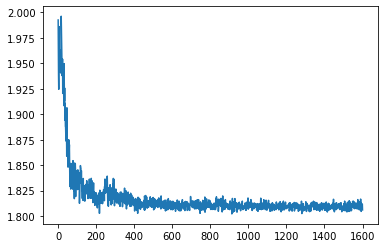

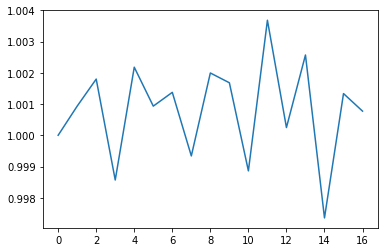


 ### SAVE MODEL ### 

at iter 1610 ELBO loss metric 1.8090494871139526
at iter 1620 ELBO loss metric 1.8075833320617676
at iter 1630 ELBO loss metric 1.8110733032226562
at iter 1640 ELBO loss metric 1.8104344606399536
at iter 1650 ELBO loss metric 1.8097052574157715
at iter 1660 ELBO loss metric 1.8103320598602295
at iter 1670 ELBO loss metric 1.8113367557525635
at iter 1680 ELBO loss metric 1.8094124794006348
at iter 1690 ELBO loss metric 1.808030605316162
at iter 1700 ELBO loss metric 1.8101685047149658

 ldj check 1.0030676126480103 

at iter 1710 ELBO loss metric 1.811607837677002
at iter 1720 ELBO loss metric 1.8116594552993774
at iter 1730 ELBO loss metric 1.8087573051452637
at iter 1740 ELBO loss metric 1.8058629035949707
at iter 1750 ELBO loss metric 1.8098118305206299
at iter 1760 ELBO loss metric 1.809565544128418
at iter 1770 ELBO loss metric 1.812726616859436
at iter 1780 ELBO loss metric 1.8122836351394653
at iter 1790 ELBO loss metric 1.8065638542175293
at iter 1800 ELBO

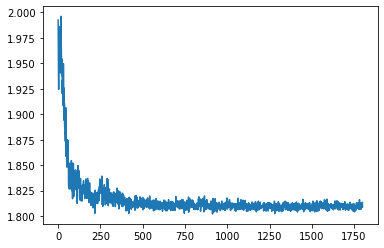

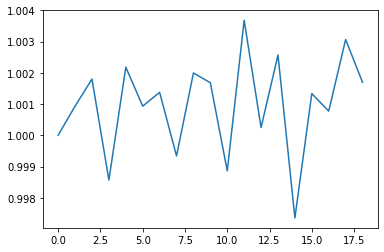


 ### SAVE MODEL ### 

at iter 1810 ELBO loss metric 1.8138140439987183
at iter 1820 ELBO loss metric 1.8062320947647095
at iter 1830 ELBO loss metric 1.8067905902862549
at iter 1840 ELBO loss metric 1.809065341949463
at iter 1850 ELBO loss metric 1.8078832626342773
at iter 1860 ELBO loss metric 1.8092209100723267
at iter 1870 ELBO loss metric 1.8102620840072632
at iter 1880 ELBO loss metric 1.8067610263824463
at iter 1890 ELBO loss metric 1.8138647079467773
at iter 1900 ELBO loss metric 1.8097319602966309

 ldj check 1.002122163772583 

at iter 1910 ELBO loss metric 1.8072453737258911
at iter 1920 ELBO loss metric 1.8095736503601074
at iter 1930 ELBO loss metric 1.810482144355774
at iter 1940 ELBO loss metric 1.8118512630462646
at iter 1950 ELBO loss metric 1.8108792304992676
at iter 1960 ELBO loss metric 1.8088335990905762
at iter 1970 ELBO loss metric 1.8051822185516357
at iter 1980 ELBO loss metric 1.8097432851791382
at iter 1990 ELBO loss metric 1.8086559772491455

run 4 with seed

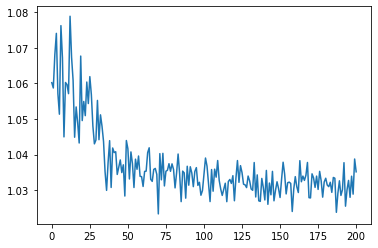

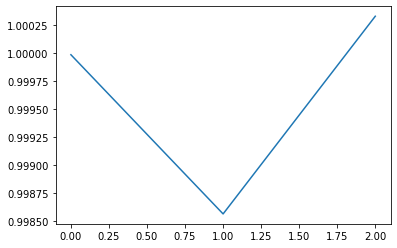


 ### SAVE MODEL ### 

at iter 210 ELBO loss metric 1.0331741571426392
at iter 220 ELBO loss metric 1.0346516370773315
at iter 230 ELBO loss metric 1.0299177169799805
at iter 240 ELBO loss metric 1.0302040576934814
at iter 250 ELBO loss metric 1.031797170639038
at iter 260 ELBO loss metric 1.0271269083023071
at iter 270 ELBO loss metric 1.0326836109161377
at iter 280 ELBO loss metric 1.0291078090667725
at iter 290 ELBO loss metric 1.0267053842544556
at iter 300 ELBO loss metric 1.0299489498138428

 ldj check 1.0001972913742065 

at iter 310 ELBO loss metric 1.0232973098754883
at iter 320 ELBO loss metric 1.025691032409668
at iter 330 ELBO loss metric 1.0257017612457275
at iter 340 ELBO loss metric 1.0302683115005493
at iter 350 ELBO loss metric 1.0301318168640137
at iter 360 ELBO loss metric 1.0306476354599
at iter 370 ELBO loss metric 1.0264341831207275
at iter 380 ELBO loss metric 1.0253267288208008
at iter 390 ELBO loss metric 1.0286238193511963
at iter 400 ELBO loss metric 1.030771

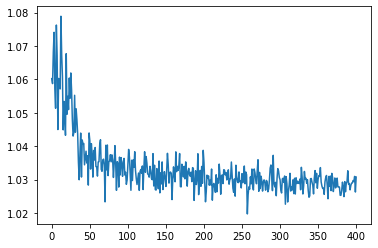

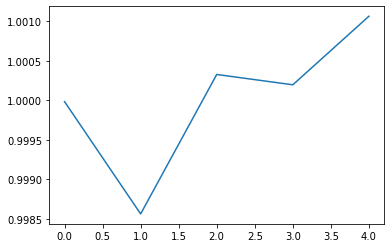


 ### SAVE MODEL ### 

at iter 410 ELBO loss metric 1.0289297103881836
at iter 420 ELBO loss metric 1.0248298645019531
at iter 430 ELBO loss metric 1.02837073802948
at iter 440 ELBO loss metric 1.030531883239746
at iter 450 ELBO loss metric 1.0286709070205688
at iter 460 ELBO loss metric 1.0272812843322754
at iter 470 ELBO loss metric 1.0270777940750122
at iter 480 ELBO loss metric 1.0267354249954224
at iter 490 ELBO loss metric 1.0300222635269165
at iter 500 ELBO loss metric 1.027552604675293

 ldj check 1.0012009143829346 

at iter 510 ELBO loss metric 1.0289263725280762
at iter 520 ELBO loss metric 1.0275800228118896
at iter 530 ELBO loss metric 1.0290610790252686
at iter 540 ELBO loss metric 1.0305073261260986
at iter 550 ELBO loss metric 1.0283489227294922
at iter 560 ELBO loss metric 1.0285899639129639
at iter 570 ELBO loss metric 1.0280113220214844
at iter 580 ELBO loss metric 1.0295475721359253
at iter 590 ELBO loss metric 1.029611349105835
at iter 600 ELBO loss metric 1.029084

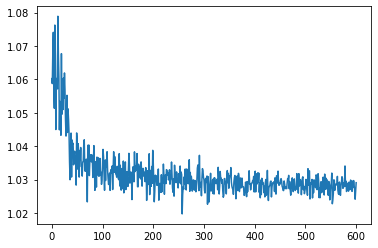

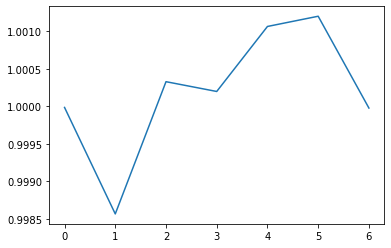


 ### SAVE MODEL ### 

at iter 610 ELBO loss metric 1.027547001838684
at iter 620 ELBO loss metric 1.0254905223846436
at iter 630 ELBO loss metric 1.0307657718658447
at iter 640 ELBO loss metric 1.0287754535675049
at iter 650 ELBO loss metric 1.0262339115142822
at iter 660 ELBO loss metric 1.027787685394287
at iter 670 ELBO loss metric 1.029166579246521
at iter 680 ELBO loss metric 1.026087999343872
at iter 690 ELBO loss metric 1.0325844287872314
at iter 700 ELBO loss metric 1.0261857509613037

 ldj check 0.9997109174728394 

at iter 710 ELBO loss metric 1.0296860933303833
at iter 720 ELBO loss metric 1.0273470878601074
at iter 730 ELBO loss metric 1.0256069898605347
at iter 740 ELBO loss metric 1.0287501811981201
at iter 750 ELBO loss metric 1.0274204015731812
at iter 760 ELBO loss metric 1.0313475131988525
at iter 770 ELBO loss metric 1.0277576446533203
at iter 780 ELBO loss metric 1.029498815536499
at iter 790 ELBO loss metric 1.0244251489639282
at iter 800 ELBO loss metric 1.027409

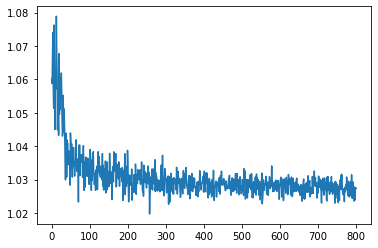

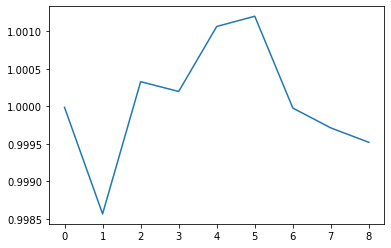


 ### SAVE MODEL ### 

at iter 810 ELBO loss metric 1.0258811712265015
at iter 820 ELBO loss metric 1.0299733877182007
at iter 830 ELBO loss metric 1.0307470560073853
at iter 840 ELBO loss metric 1.026313066482544
at iter 850 ELBO loss metric 1.0252323150634766
at iter 860 ELBO loss metric 1.0241775512695312
at iter 870 ELBO loss metric 1.0301753282546997
at iter 880 ELBO loss metric 1.0272026062011719
at iter 890 ELBO loss metric 1.0328298807144165
at iter 900 ELBO loss metric 1.028306245803833

 ldj check 0.998784601688385 

at iter 910 ELBO loss metric 1.029293179512024
at iter 920 ELBO loss metric 1.0284703969955444
at iter 930 ELBO loss metric 1.02982497215271
at iter 940 ELBO loss metric 1.0300853252410889
at iter 950 ELBO loss metric 1.024869441986084
at iter 960 ELBO loss metric 1.0296080112457275
at iter 970 ELBO loss metric 1.0253267288208008
at iter 980 ELBO loss metric 1.0275702476501465
at iter 990 ELBO loss metric 1.0276604890823364
at iter 1000 ELBO loss metric 1.0288771

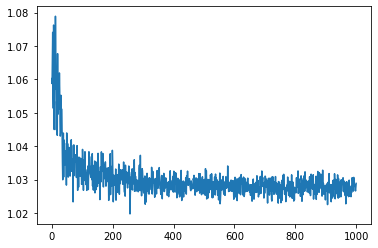

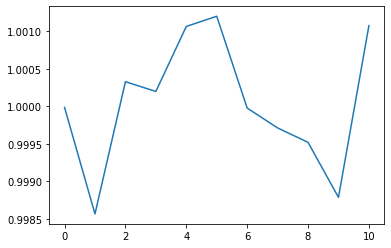


 ### SAVE MODEL ### 

at iter 1010 ELBO loss metric 1.0259976387023926
at iter 1020 ELBO loss metric 1.0313973426818848
at iter 1030 ELBO loss metric 1.0245187282562256
at iter 1040 ELBO loss metric 1.027803659439087
at iter 1050 ELBO loss metric 1.029737949371338
at iter 1060 ELBO loss metric 1.0293245315551758
at iter 1070 ELBO loss metric 1.027928113937378
at iter 1080 ELBO loss metric 1.0284274816513062
at iter 1090 ELBO loss metric 1.0291624069213867
at iter 1100 ELBO loss metric 1.0267179012298584

 ldj check 0.9991918206214905 

at iter 1110 ELBO loss metric 1.0279366970062256
at iter 1120 ELBO loss metric 1.0285348892211914
at iter 1130 ELBO loss metric 1.0304632186889648
at iter 1140 ELBO loss metric 1.0299513339996338
at iter 1150 ELBO loss metric 1.0275276899337769
at iter 1160 ELBO loss metric 1.024172067642212
at iter 1170 ELBO loss metric 1.0282773971557617
at iter 1180 ELBO loss metric 1.027857780456543
at iter 1190 ELBO loss metric 1.0306774377822876
at iter 1200 ELBO 

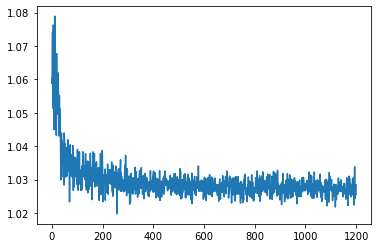

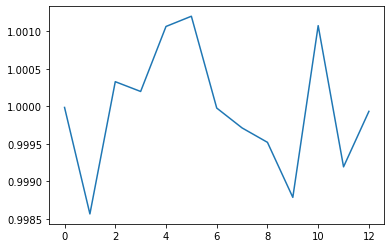


 ### SAVE MODEL ### 

at iter 1210 ELBO loss metric 1.02996027469635
at iter 1220 ELBO loss metric 1.0296335220336914
at iter 1230 ELBO loss metric 1.0280081033706665
at iter 1240 ELBO loss metric 1.0270593166351318
at iter 1250 ELBO loss metric 1.0265802145004272
at iter 1260 ELBO loss metric 1.0265905857086182
at iter 1270 ELBO loss metric 1.0291105508804321
at iter 1280 ELBO loss metric 1.028941035270691
at iter 1290 ELBO loss metric 1.02736234664917
at iter 1300 ELBO loss metric 1.0279510021209717

 ldj check 1.0015050172805786 

at iter 1310 ELBO loss metric 1.0274837017059326
at iter 1320 ELBO loss metric 1.0266096591949463
at iter 1330 ELBO loss metric 1.0277550220489502
at iter 1340 ELBO loss metric 1.0282877683639526
at iter 1350 ELBO loss metric 1.0283523797988892
at iter 1360 ELBO loss metric 1.027495265007019
at iter 1370 ELBO loss metric 1.029855489730835
at iter 1380 ELBO loss metric 1.0274767875671387
at iter 1390 ELBO loss metric 1.0250377655029297
at iter 1400 ELBO lo

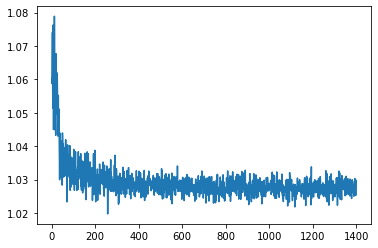

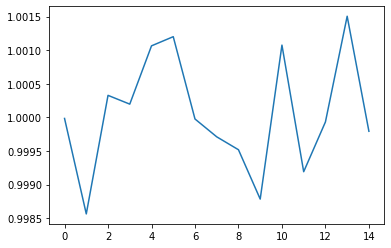


 ### SAVE MODEL ### 

at iter 1410 ELBO loss metric 1.0273737907409668
at iter 1420 ELBO loss metric 1.024294376373291
at iter 1430 ELBO loss metric 1.0233887434005737
at iter 1440 ELBO loss metric 1.0262315273284912
at iter 1450 ELBO loss metric 1.0264675617218018
at iter 1460 ELBO loss metric 1.0253326892852783
at iter 1470 ELBO loss metric 1.0295348167419434
at iter 1480 ELBO loss metric 1.0292327404022217
at iter 1490 ELBO loss metric 1.0294065475463867
at iter 1500 ELBO loss metric 1.0285122394561768

 ldj check 0.9983240962028503 

at iter 1510 ELBO loss metric 1.0264235734939575
at iter 1520 ELBO loss metric 1.028963565826416
at iter 1530 ELBO loss metric 1.0271058082580566
at iter 1540 ELBO loss metric 1.0236790180206299
at iter 1550 ELBO loss metric 1.0274698734283447
at iter 1560 ELBO loss metric 1.0305571556091309
at iter 1570 ELBO loss metric 1.027171015739441
at iter 1580 ELBO loss metric 1.0256059169769287
at iter 1590 ELBO loss metric 1.0245862007141113
at iter 1600 ELB

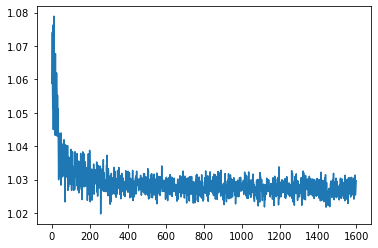

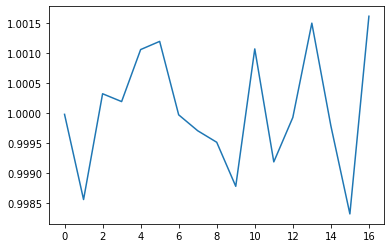


 ### SAVE MODEL ### 

at iter 1610 ELBO loss metric 1.0278902053833008
at iter 1620 ELBO loss metric 1.0253071784973145
at iter 1630 ELBO loss metric 1.0265718698501587
at iter 1640 ELBO loss metric 1.0266669988632202
at iter 1650 ELBO loss metric 1.0268800258636475
at iter 1660 ELBO loss metric 1.0267012119293213
at iter 1670 ELBO loss metric 1.0302094221115112
at iter 1680 ELBO loss metric 1.0256013870239258
at iter 1690 ELBO loss metric 1.0286380052566528
at iter 1700 ELBO loss metric 1.0269275903701782

 ldj check 0.9995546340942383 

at iter 1710 ELBO loss metric 1.0272464752197266
at iter 1720 ELBO loss metric 1.0251359939575195
at iter 1730 ELBO loss metric 1.0283905267715454
at iter 1740 ELBO loss metric 1.0277653932571411
at iter 1750 ELBO loss metric 1.0252584218978882
at iter 1760 ELBO loss metric 1.0231122970581055
at iter 1770 ELBO loss metric 1.0258183479309082
at iter 1780 ELBO loss metric 1.0275840759277344
at iter 1790 ELBO loss metric 1.0267161130905151
at iter 1800 

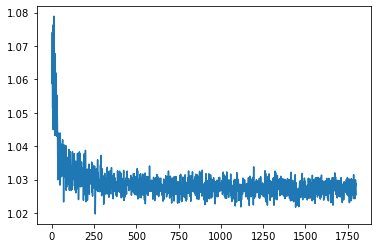

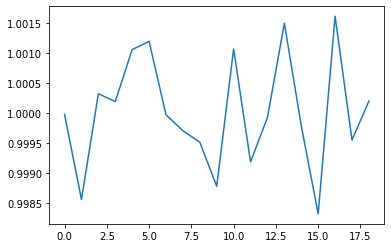


 ### SAVE MODEL ### 

at iter 1810 ELBO loss metric 1.0296375751495361
at iter 1820 ELBO loss metric 1.0256528854370117
at iter 1830 ELBO loss metric 1.0268222093582153
at iter 1840 ELBO loss metric 1.0289969444274902
at iter 1850 ELBO loss metric 1.0238598585128784
at iter 1860 ELBO loss metric 1.0274955034255981
at iter 1870 ELBO loss metric 1.024461030960083
at iter 1880 ELBO loss metric 1.028613805770874
at iter 1890 ELBO loss metric 1.0281025171279907
at iter 1900 ELBO loss metric 1.0270015001296997

 ldj check 1.0001674890518188 

at iter 1910 ELBO loss metric 1.025590419769287
at iter 1920 ELBO loss metric 1.0288212299346924
at iter 1930 ELBO loss metric 1.0249453783035278
at iter 1940 ELBO loss metric 1.0264360904693604
at iter 1950 ELBO loss metric 1.0253162384033203
at iter 1960 ELBO loss metric 1.025179386138916
at iter 1970 ELBO loss metric 1.032784342765808
at iter 1980 ELBO loss metric 1.0247015953063965
at iter 1990 ELBO loss metric 1.0272948741912842
at iter 0 ELBO los

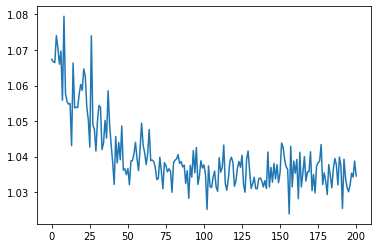

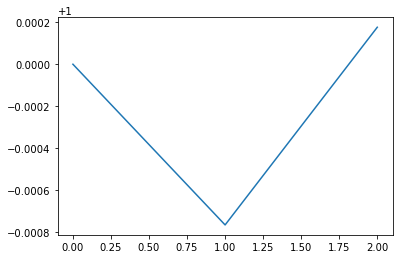


 ### SAVE MODEL ### 

at iter 210 ELBO loss metric 1.0392484664916992
at iter 220 ELBO loss metric 1.0311925411224365
at iter 230 ELBO loss metric 1.0382544994354248
at iter 240 ELBO loss metric 1.0318856239318848
at iter 250 ELBO loss metric 1.0337179899215698
at iter 260 ELBO loss metric 1.026219367980957
at iter 270 ELBO loss metric 1.0308198928833008
at iter 280 ELBO loss metric 1.031064510345459
at iter 290 ELBO loss metric 1.0328036546707153
at iter 300 ELBO loss metric 1.0318982601165771

 ldj check 0.9994208216667175 

at iter 310 ELBO loss metric 1.0349762439727783
at iter 320 ELBO loss metric 1.0289801359176636
at iter 330 ELBO loss metric 1.0252939462661743
at iter 340 ELBO loss metric 1.028422474861145
at iter 350 ELBO loss metric 1.0361253023147583
at iter 360 ELBO loss metric 1.0287623405456543
at iter 370 ELBO loss metric 1.0300570726394653
at iter 380 ELBO loss metric 1.0338852405548096
at iter 390 ELBO loss metric 1.029305338859558
at iter 400 ELBO loss metric 1.03110

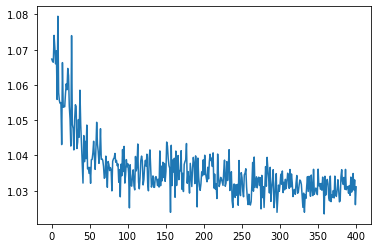

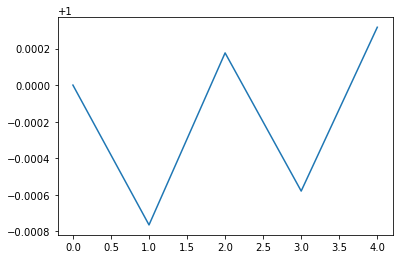


 ### SAVE MODEL ### 

at iter 410 ELBO loss metric 1.0235852003097534
at iter 420 ELBO loss metric 1.0271788835525513
at iter 430 ELBO loss metric 1.030944585800171
at iter 440 ELBO loss metric 1.0279978513717651
at iter 450 ELBO loss metric 1.0241179466247559
at iter 460 ELBO loss metric 1.0316517353057861
at iter 470 ELBO loss metric 1.0315172672271729
at iter 480 ELBO loss metric 1.032716989517212
at iter 490 ELBO loss metric 1.029172658920288
at iter 500 ELBO loss metric 1.0313072204589844

 ldj check 1.0000730752944946 

at iter 510 ELBO loss metric 1.0306885242462158
at iter 520 ELBO loss metric 1.0285913944244385
at iter 530 ELBO loss metric 1.028764247894287
at iter 540 ELBO loss metric 1.0298097133636475
at iter 550 ELBO loss metric 1.0309813022613525
at iter 560 ELBO loss metric 1.0253467559814453
at iter 570 ELBO loss metric 1.0285582542419434
at iter 580 ELBO loss metric 1.0303316116333008
at iter 590 ELBO loss metric 1.0291476249694824
at iter 600 ELBO loss metric 1.02666

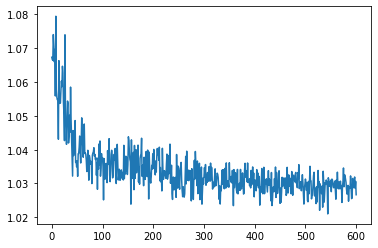

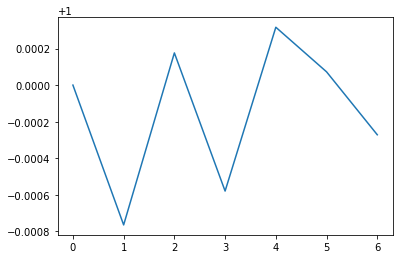


 ### SAVE MODEL ### 

at iter 610 ELBO loss metric 1.0292389392852783
at iter 620 ELBO loss metric 1.0293335914611816
at iter 630 ELBO loss metric 1.0310626029968262
at iter 640 ELBO loss metric 1.0300211906433105
at iter 650 ELBO loss metric 1.027255654335022
at iter 660 ELBO loss metric 1.0284119844436646
at iter 670 ELBO loss metric 1.0295953750610352
at iter 680 ELBO loss metric 1.0320662260055542
at iter 690 ELBO loss metric 1.026538610458374
at iter 700 ELBO loss metric 1.0294245481491089

 ldj check 1.0011942386627197 

at iter 710 ELBO loss metric 1.0288262367248535
at iter 720 ELBO loss metric 1.0288686752319336
at iter 730 ELBO loss metric 1.0301783084869385
at iter 740 ELBO loss metric 1.0228756666183472
at iter 750 ELBO loss metric 1.0263930559158325
at iter 760 ELBO loss metric 1.0281140804290771
at iter 770 ELBO loss metric 1.0280675888061523
at iter 780 ELBO loss metric 1.0343679189682007
at iter 790 ELBO loss metric 1.0255753993988037
at iter 800 ELBO loss metric 1.024

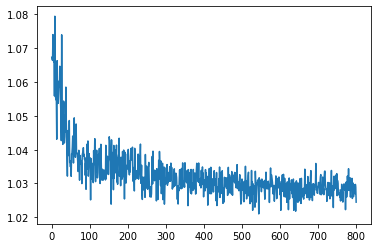

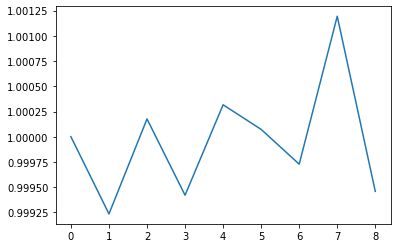


 ### SAVE MODEL ### 

at iter 810 ELBO loss metric 1.0322487354278564
at iter 820 ELBO loss metric 1.0307462215423584
at iter 830 ELBO loss metric 1.0273221731185913
at iter 840 ELBO loss metric 1.0282793045043945
at iter 850 ELBO loss metric 1.0283994674682617
at iter 860 ELBO loss metric 1.0275131464004517
at iter 870 ELBO loss metric 1.0272369384765625
at iter 880 ELBO loss metric 1.0301613807678223
at iter 890 ELBO loss metric 1.0244109630584717
at iter 900 ELBO loss metric 1.0262681245803833

 ldj check 0.9998083114624023 

at iter 910 ELBO loss metric 1.0303432941436768
at iter 920 ELBO loss metric 1.0289158821105957
at iter 930 ELBO loss metric 1.0272897481918335
at iter 940 ELBO loss metric 1.02748441696167
at iter 950 ELBO loss metric 1.0293903350830078
at iter 960 ELBO loss metric 1.029127836227417
at iter 970 ELBO loss metric 1.0261898040771484
at iter 980 ELBO loss metric 1.0278890132904053
at iter 990 ELBO loss metric 1.0275176763534546
at iter 1000 ELBO loss metric 1.028

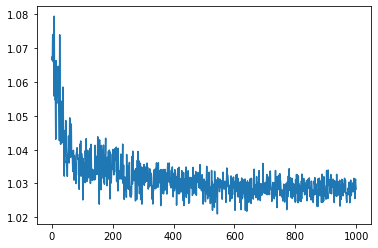

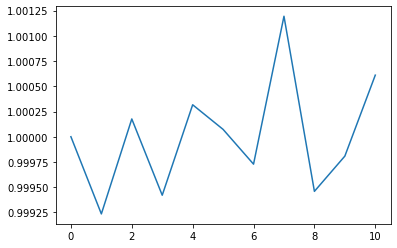


 ### SAVE MODEL ### 

at iter 1010 ELBO loss metric 1.028230905532837
at iter 1020 ELBO loss metric 1.0254912376403809
at iter 1030 ELBO loss metric 1.0295350551605225
at iter 1040 ELBO loss metric 1.02570378780365
at iter 1050 ELBO loss metric 1.030380368232727
at iter 1060 ELBO loss metric 1.0344610214233398
at iter 1070 ELBO loss metric 1.0248974561691284
at iter 1080 ELBO loss metric 1.0300573110580444
at iter 1090 ELBO loss metric 1.026961088180542
at iter 1100 ELBO loss metric 1.0226695537567139

 ldj check 1.0007494688034058 

at iter 1110 ELBO loss metric 1.0281460285186768
at iter 1120 ELBO loss metric 1.0302538871765137
at iter 1130 ELBO loss metric 1.0290062427520752
at iter 1140 ELBO loss metric 1.0315253734588623
at iter 1150 ELBO loss metric 1.0225772857666016
at iter 1160 ELBO loss metric 1.030718445777893
at iter 1170 ELBO loss metric 1.0276107788085938
at iter 1180 ELBO loss metric 1.0306191444396973
at iter 1190 ELBO loss metric 1.0250427722930908
at iter 1200 ELBO l

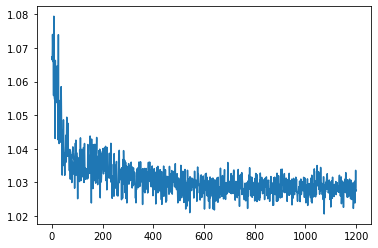

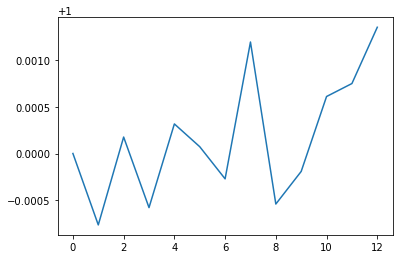


 ### SAVE MODEL ### 

at iter 1210 ELBO loss metric 1.025754690170288
at iter 1220 ELBO loss metric 1.0353177785873413
at iter 1230 ELBO loss metric 1.02986741065979
at iter 1240 ELBO loss metric 1.0287740230560303
at iter 1250 ELBO loss metric 1.0277334451675415
at iter 1260 ELBO loss metric 1.0271084308624268
at iter 1270 ELBO loss metric 1.025918960571289
at iter 1280 ELBO loss metric 1.0257710218429565
at iter 1290 ELBO loss metric 1.0313148498535156
at iter 1300 ELBO loss metric 1.0259612798690796

 ldj check 0.9979963302612305 

at iter 1310 ELBO loss metric 1.0256692171096802
at iter 1320 ELBO loss metric 1.031804084777832
at iter 1330 ELBO loss metric 1.0287485122680664
at iter 1340 ELBO loss metric 1.0308094024658203
at iter 1350 ELBO loss metric 1.031273603439331
at iter 1360 ELBO loss metric 1.0297391414642334
at iter 1370 ELBO loss metric 1.027420163154602
at iter 1380 ELBO loss metric 1.024104356765747
at iter 1390 ELBO loss metric 1.0224744081497192
at iter 1400 ELBO los

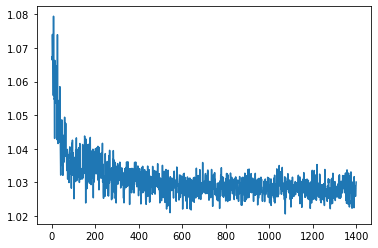

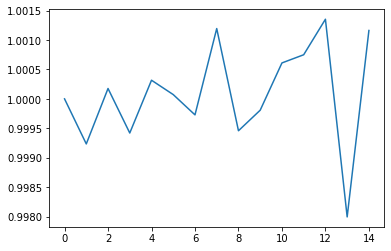


 ### SAVE MODEL ### 

at iter 1410 ELBO loss metric 1.026092767715454
at iter 1420 ELBO loss metric 1.031345009803772
at iter 1430 ELBO loss metric 1.0259442329406738
at iter 1440 ELBO loss metric 1.0260595083236694
at iter 1450 ELBO loss metric 1.0259207487106323
at iter 1460 ELBO loss metric 1.0255093574523926
at iter 1470 ELBO loss metric 1.02523672580719
at iter 1480 ELBO loss metric 1.024010419845581
at iter 1490 ELBO loss metric 1.025820016860962
at iter 1500 ELBO loss metric 1.0263645648956299

 ldj check 1.0001376867294312 

at iter 1510 ELBO loss metric 1.0288056135177612
at iter 1520 ELBO loss metric 1.0238430500030518
at iter 1530 ELBO loss metric 1.0292153358459473
at iter 1540 ELBO loss metric 1.0297964811325073
at iter 1550 ELBO loss metric 1.0282042026519775
at iter 1560 ELBO loss metric 1.0283968448638916
at iter 1570 ELBO loss metric 1.029251217842102
at iter 1580 ELBO loss metric 1.0295263528823853
at iter 1590 ELBO loss metric 1.028613567352295
at iter 1600 ELBO los

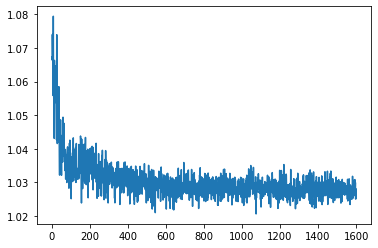

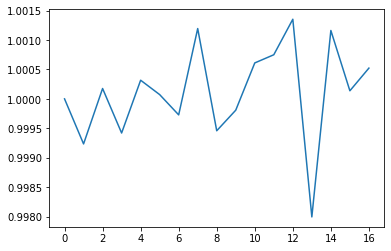


 ### SAVE MODEL ### 

at iter 1610 ELBO loss metric 1.0277982950210571
at iter 1620 ELBO loss metric 1.0268934965133667
at iter 1630 ELBO loss metric 1.0330665111541748
at iter 1640 ELBO loss metric 1.029853343963623
at iter 1650 ELBO loss metric 1.025331735610962
at iter 1660 ELBO loss metric 1.023210048675537
at iter 1670 ELBO loss metric 1.0302202701568604
at iter 1680 ELBO loss metric 1.0288798809051514
at iter 1690 ELBO loss metric 1.0255403518676758
at iter 1700 ELBO loss metric 1.0263123512268066

 ldj check 1.000006079673767 

at iter 1710 ELBO loss metric 1.0272678136825562
at iter 1720 ELBO loss metric 1.0251331329345703
at iter 1730 ELBO loss metric 1.0284223556518555
at iter 1740 ELBO loss metric 1.0281459093093872
at iter 1750 ELBO loss metric 1.0269070863723755
at iter 1760 ELBO loss metric 1.0252889394760132
at iter 1770 ELBO loss metric 1.0289446115493774
at iter 1780 ELBO loss metric 1.0226496458053589
at iter 1790 ELBO loss metric 1.025378704071045
at iter 1800 ELBO 

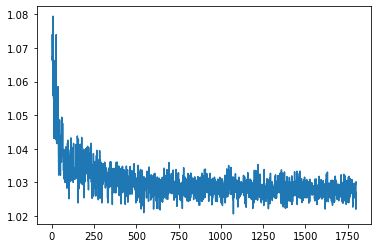

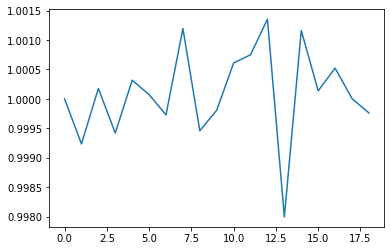


 ### SAVE MODEL ### 

at iter 1810 ELBO loss metric 1.029771089553833
at iter 1820 ELBO loss metric 1.0301653146743774
at iter 1830 ELBO loss metric 1.027417540550232
at iter 1840 ELBO loss metric 1.0305724143981934
at iter 1850 ELBO loss metric 1.0268207788467407
at iter 1860 ELBO loss metric 1.0280253887176514
at iter 1870 ELBO loss metric 1.0250529050827026
at iter 1880 ELBO loss metric 1.0277070999145508
at iter 1890 ELBO loss metric 1.0295161008834839
at iter 1900 ELBO loss metric 1.030550241470337

 ldj check 1.0006916522979736 

at iter 1910 ELBO loss metric 1.028660774230957
at iter 1920 ELBO loss metric 1.030322551727295
at iter 1930 ELBO loss metric 1.0283300876617432
at iter 1940 ELBO loss metric 1.0262891054153442
at iter 1950 ELBO loss metric 1.029821515083313
at iter 1960 ELBO loss metric 1.0289642810821533
at iter 1970 ELBO loss metric 1.0268104076385498
at iter 1980 ELBO loss metric 1.0279784202575684
at iter 1990 ELBO loss metric 1.0312421321868896


In [10]:

train_both_models_combined(seeds, path='3D')

### train here 16 x 16 matrix 
### seperately for Circle Slice and Cylindrical Flows

In [ ]:
### have to set A = equiv_matrix before starting

In [ ]:
### cou cylindrical moebius model
cyl_cou_moeb = Cylindrical_Flow(num_flows=NUM_FLOWS_COU,
                                 num_bins=NUM_BINS, 
                                 flow_type='moebius',
                                 num_dim_data=NUM_DIM_DATA, 
                                 mask_type='coupling',
                                 num_centers=NUM_CENTERS)

cyl_cou_moeb.to(device)

optimizer_cyl_cou = optim.AdamW(cyl_cou_moeb.parameters())

In [ ]:
### coupling moebius model 
cou_moeb = Coupling_Flow(num_flows = NUM_FLOWS_COU, 
                              num_dim_data= NUM_DIM_DATA,
                              flow_type = 'moebius', 
                              num_centers = NUM_CENTERS,
                              cap_householder_refl=CAP_HOUSEHOLDER_REFL)

cou_moeb.to(device)

optimizer = optim.AdamW(cou_moeb.parameters())

In [ ]:
### train cou cyl moeb
max_iter = int(40e3)
train_model(cyl_cou_moeb, optimizer_cyl_cou, A, model_name='cyl_moeb_v5', max_iter = max_iter)

In [ ]:
max_iter = int(40e3)
train_model(cou_moeb, optimizer, A, model_name='cou_moeb_v5', max_iter = max_iter)

### load trained model and continue training

In [ ]:
cou_moeb = Coupling_Flow(num_flows=NUM_FLOWS_COU, 
                              num_dim_data=NUM_DIM_DATA,
                              flow_type='moebius', 
                              num_centers=NUM_CENTERS,
                              cap_householder_refl=CAP_HOUSEHOLDER_REFL)

cou_moeb.to(device)

optimizer = optim.AdamW(cou_moeb.parameters())

state = torch.load('det_estimate_model/cou_moeb_in_3d_2.t7')


cou_moeb.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])




In [ ]:
ELBO_list = np.load('det_estimate_model/ELBO_list_cou_moeb_v5.npy',allow_pickle=True)
dj_list = np.load('det_estimate_model/dj_list_cou_moeb_v5.npy',allow_pickle=True)

max_iter = int(40e3)
train_model(cou_moeb, 
            optimizer, 
            A, 
            model_name='cou_moeb_v5', 
            max_iter = max_iter,
            ELBO_list = ELBO_list,
            dj_list = dj_list)

In [ ]:
### cou cylindrical moebius model
cyl_cou_moeb = Cylindrical_Flow(num_flows=NUM_FLOWS_COU,
                                 num_bins=NUM_BINS, 
                                 flow_type='moebius',
                                 num_dim_data=NUM_DIM_DATA, 
                                 mask_type='coupling',
                                 num_centers=NUM_CENTERS)

cyl_cou_moeb.to(device)

optimizer_cyl_cou = optim.AdamW(cyl_cou_moeb.parameters())



state = torch.load('det_estimate_model/cyl_cou_moeb_v5.t7')

cyl_cou_moeb.load_state_dict(state['state_dict'])
optimizer_cyl_cou.load_state_dict(state['optimizer'])

In [ ]:

ELBO_list = np.load('det_estimate_model/ELBO_list_cyl_cou_moeb_v5.npy',allow_pickle=True)
dj_list = np.load('det_estimate_model/dj_list_cyl_cou_moeb_v5.npy',allow_pickle=True)

max_iter = int(40e3)
train_model(cyl_cou_moeb, 
            optimizer_cyl_cou, 
            A, 
            model_name='cyl_cou_moeb_v5', 
            max_iter = max_iter,
            ELBO_list = ELBO_list,
            dj_list = dj_list)